# Preparation

## Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.inspection import permutation_importance


from fetchData import fetchdata, cv_events
import __MLP
# from __MLP import getSamplers, convert_df_to_unsqueezed_tensor, train_sequential, clf_report
import random

import __Preprocessing
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

pd.set_option('display.max_columns', None)

In [4]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [5]:
seed = 42
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)


torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = False

def _init_fn(worker_id):
    np.random.seed(int(seed))

def test_data_process(X_test, y_test):
    tensor_x1 = torch.Tensor(X_test.values).unsqueeze(1)
    tensor_y1 = torch.Tensor(y_test.values).unsqueeze(1)
    test_dataset = TensorDataset(tensor_x1,tensor_y1)

    batch_size = 8

    # train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    data = next(iter(test_dataloader))
    print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

    test_size = int(tensor_y1.size(0))

    print("Test Size",test_size)

    # predict_batch
    return test_dataloader, test_size


def test_data_process(X_test, y_test):

    tensor_x1 = torch.Tensor(X_test.values).unsqueeze(1)
    tensor_y1 = torch.Tensor(y_test.values).unsqueeze(1)
    test_dataset = TensorDataset(tensor_x1,tensor_y1)

    batch_size = 8

    # train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    data = next(iter(test_dataloader))
    print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

    test_size = int(tensor_y1.size(0))

    print("Test Size",test_size)

    # predict_batch
    return test_dataloader, test_size
def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    val_label_list = []
    # val_preds_list = []
    running_val_preds = []

    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        f1_running = 0
        for j, val in enumerate(val_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            val_preds = val_outputs.squeeze(1) > 0.0
            f1_running += (f1_score(val_label, val_preds,zero_division=True) * val_x.size(0))
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label)
            val_label_list.append(val_label)
            running_val_preds.append(val_preds)

    running_val_preds = torch.cat(running_val_preds, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects
    val_loss = val_loss/val_size
    val_acc = val_corrects.double().numpy() / val_size
    f1_running /= val_size
    print("accuracy_score:\t\t%.4f" % val_acc)
    print('Precision Score:\t%.4f' % precision_score(val_label_list,running_val_preds))
    print('Recall Score:\t\t%.4f' % recall_score(val_label_list,running_val_preds))
    print("f1_score:\t\t%.4f" % f1_running)
    print("Test_loss:\t\t%.4f" % val_loss)


## Data

In [6]:
# Final
pheme_sparse_final = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_pos_final = pd.read_csv('./data/_PHEME_postags.csv')
pheme_thread_final_avg = pd.read_csv('./data/_PHEME_thread_avg.csv')
pheme_thread_final_std = pd.read_csv('./data/_PHEME_thread_std.csv')

ext_pos_final = pd.read_csv('./data/_PHEMEext_postags.csv')
ext_sparse_final = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_thread_final_avg = pd.read_csv('./data/_PHEMEext_thread_avg.csv')
ext_thread_final_std = pd.read_csv('./data/_PHEMEext_thread_std.csv')

pheme_bert_simple_normal = pd.read_csv('./data/_PHEME_Bert_final_brackets.csv')
pheme_bert_brackets_normal = pd.read_csv('./data/_PHEME_Bert_final_brackets_nrmzd.csv')
ext_bert_simple_normal = pd.read_csv('./data/_PHEMEext_Bert_final_brackets.csv')
ext_bert_brackets_normal = pd.read_csv('./data/_PHEMEext_Bert_final_brackets_nrmzd.csv')

pheme_event = pd.read_csv('./data/_PHEME_text.csv')['Event']
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event
pheme_AVGw2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
ext_AVGw2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)

In [7]:
print("pheme_sparse_final", pheme_sparse_final.shape)
print(pheme_sparse_final.columns, "\n")
print("pheme_pos_final", pheme_pos_final.shape)
x = zip(pheme_pos_final.columns.values, ['Interjection', 'Hashtag', 'coordinating conjunction', 'punctuation', 'at-mention', 'proper noun', 'adjective' 'determiner' 'other', 'nominal + verbal',
    'common noun', 'pronoun', 'pre/postposition/subordinating conjunction', 'adverb', 'nominal + possessive', 'verb particle', 'URL or email', 'verb incl. copula, auxiliaries',
 'existential there, predeterminers', 'proper noun + possessive', 'discourse marker'])
print(set(x), "\n")
print("pheme_thread_final", pheme_thread_final_avg.shape)
print(pheme_thread_final_avg.columns, "\n")
print("ext_bert_simple_normal", ext_bert_simple_normal.shape)
print(pheme_bert_simple_normal.columns, "\n")


pheme_sparse_final (5802, 28)
Index(['emoji_count', 'URLcount', 'has_media', 'Skepticism', 'MentionCount',
       'FirstPersonPronoun', 'SecondPersonPronoun', 'ThirdPersonPronoun',
       'test_auxiliary', 'test_tentat', 'test_certain', 'Numeral',
       'char_count', 'word_count', 'HashTag', 'has_question', 'has_exclaim',
       'has_period', 'capital_ratio', 'retweet_count', 'tweet_count',
       'listed_count', 'friends_count', 'follower_count', 'followers/friend',
       'favourites_count', 'account_age_days', 'verified'],
      dtype='object') 

pheme_pos_final (5802, 21)
{('s', 'URL or email'), ('!', 'Interjection'), ('o', 'adverb'), ('l', 'pronoun'), ('p', 'nominal + possessive'), ('x', 'discourse marker'), ('a', 'adjectivedeterminerother'), ('g', 'common noun'), ('d', 'nominal + verbal'), ('v', 'proper noun + possessive'), ('t', 'verb incl. copula, auxiliaries'), ('^', 'proper noun'), ('&', 'coordinating conjunction'), ('@', 'at-mention'), ('u', 'existential there, predetermine

In [8]:
# cv = cv_events(pd.concat([pheme_sparse, pheme_y, pheme_event],axis=1))
# X = cv[3][1].drop(['target', 'Event'],axis=1)
# y = cv[3][1].target
# val_X = cv[3][0].drop(['target', 'Event'],axis=1)
# val_y = cv[3][0].target

In [9]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = False

seed = 42

def _init_fn(worker_id):
    np.random.seed(int(seed))

# Feature Importance

In [74]:
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance


NameError: name 'X' is not defined

In [73]:
import xgboost
print(xgboost.__version__)

XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


In [78]:
def f_imp(X, y):
    forest = ExtraTreesClassifier(n_estimators=250,
                                random_state=3)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d: %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    
    plt.figure(figsize=(18, 7))
    size=20
    params = {'legend.fontsize': 'large',
            'figure.figsize': (20,8),
            'axes.labelsize': size,
            'axes.titlesize': size,
            'xtick.labelsize': size*0.75,
            'ytick.labelsize': size*0.75,
            'axes.titlepad': 25}
    plt.rcParams.update(params)
    plt.title("Feature importances")
    plt.bar( X.columns[indices], importances[indices], color="r")
    plt.tight_layout()
    plt.show()

def f_imp3(X, y):
    model = KNeighborsRegressor()
    # fit the model
    model.fit(X, y)
    # perform permutation importance
    results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
    # get importance
    importance = results.importances_mean
    indices = np.argsort(importances)[::-1]

    for f in range(X.shape[1]):
        print("%d. feature %d: %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

In [79]:
f_imp3(pheme_pos_final, pheme_y)

Feature ranking:
1. feature 10: n (0.106332)
2. feature 5: ^ (0.102510)
3. feature 17: v (0.096279)
4. feature 3: , (0.093341)
5. feature 12: p (0.091461)
6. feature 6: a (0.075591)
7. feature 7: d (0.074252)
8. feature 1: # (0.059265)
9. feature 16: u (0.054496)
10. feature 13: r (0.049588)
11. feature 11: o (0.043774)
12. feature 2: & (0.031883)
13. feature 4: @ (0.028695)
14. feature 15: t (0.018552)
15. feature 9: l (0.018151)
16. feature 19: z (0.015615)
17. feature 8: g (0.010001)
18. feature 14: s (0.008216)
19. feature 20: ~ (0.007611)
20. feature 18: x (0.007377)
21. feature 0: ! (0.007010)


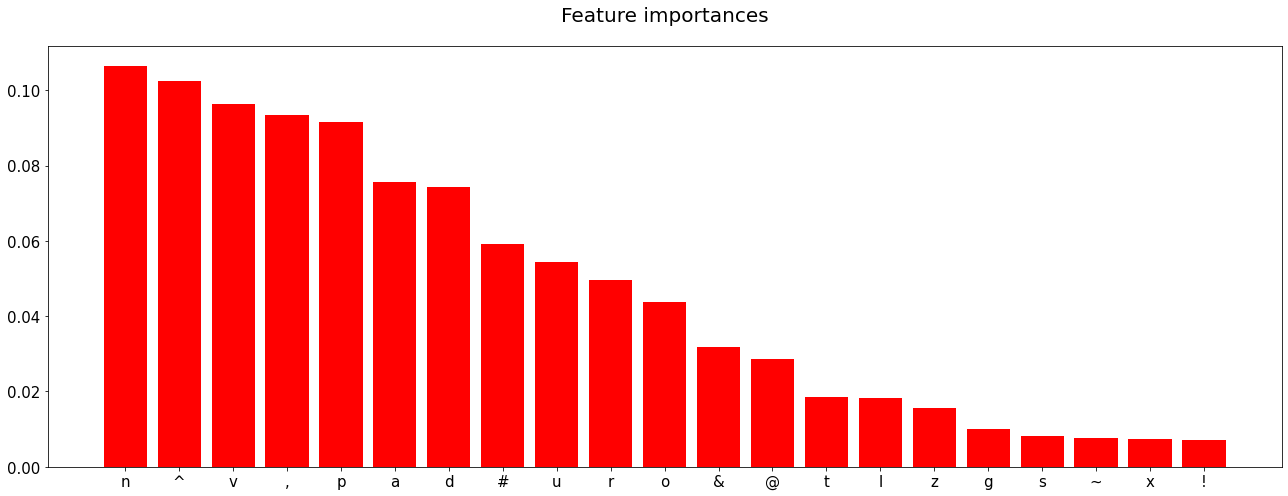

In [70]:
f_imp(pheme_pos_final, pheme_y)

Feature ranking:
1. feature 18: capital_ratio (0.072665)
2. feature 20: tweet_count (0.068413)
3. feature 21: listed_count (0.059259)
4. feature 12: char_count (0.059152)
5. feature 13: word_count (0.058236)
6. feature 23: follower_count (0.058235)
7. feature 26: account_age_days (0.057718)
8. feature 24: followers/friend (0.057397)
9. feature 25: favourites_count (0.055084)
10. feature 3: Skepticism (0.054630)
11. feature 19: retweet_count (0.053361)
12. feature 22: friends_count (0.048490)
13. feature 14: HashTag (0.043287)
14. feature 11: Numeral (0.039150)
15. feature 8: test_auxiliary (0.035239)
16. feature 5: FirstPersonPronoun (0.031446)
17. feature 1: URLcount (0.023345)
18. feature 7: ThirdPersonPronoun (0.022382)
19. feature 27: verified (0.020921)
20. feature 4: MentionCount (0.019590)
21. feature 2: has_media (0.018011)
22. feature 6: SecondPersonPronoun (0.012741)
23. feature 17: has_period (0.009337)
24. feature 15: has_question (0.008649)
25. feature 16: has_exclaim (0.0

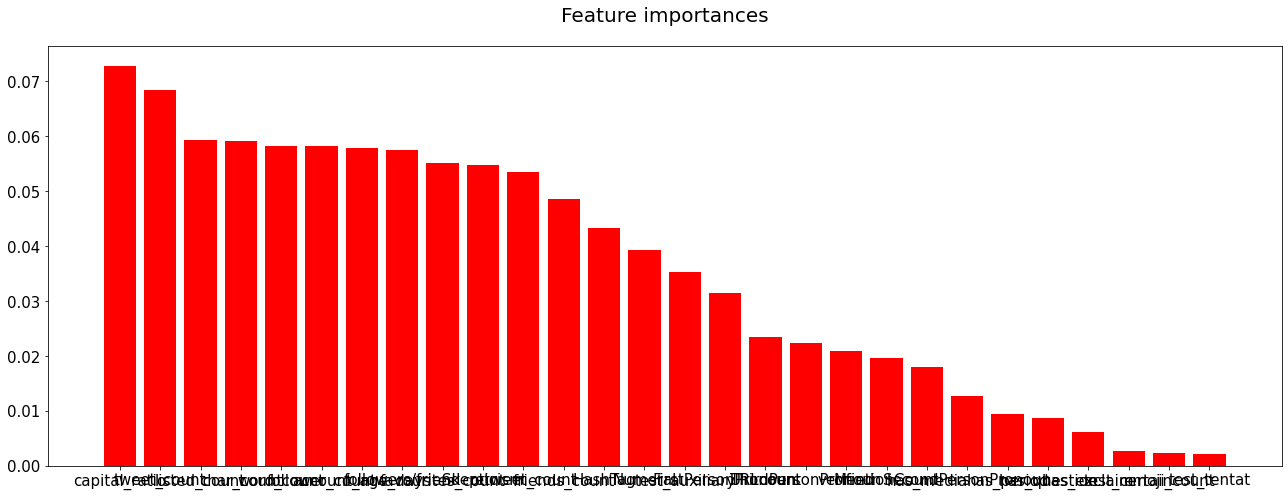

In [71]:
f_imp(pheme_sparse_final, pheme_y)

In [80]:
f_im(pheme_thread_final_avg, pheme_y)

NameError: name 'importances' is not defined

NameError: name 'f_im' is not defined

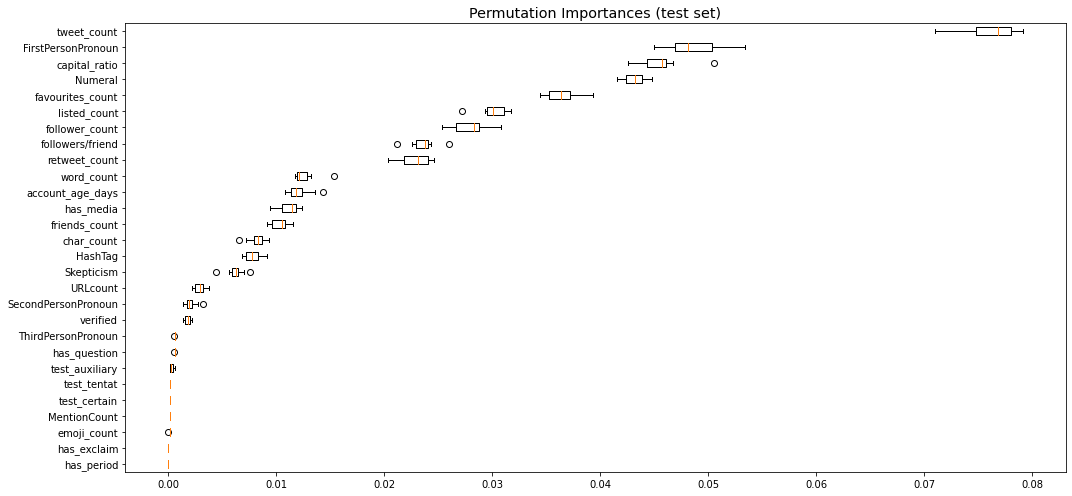

In [12]:
f_imp2(pheme_sparse_final, pheme_y)

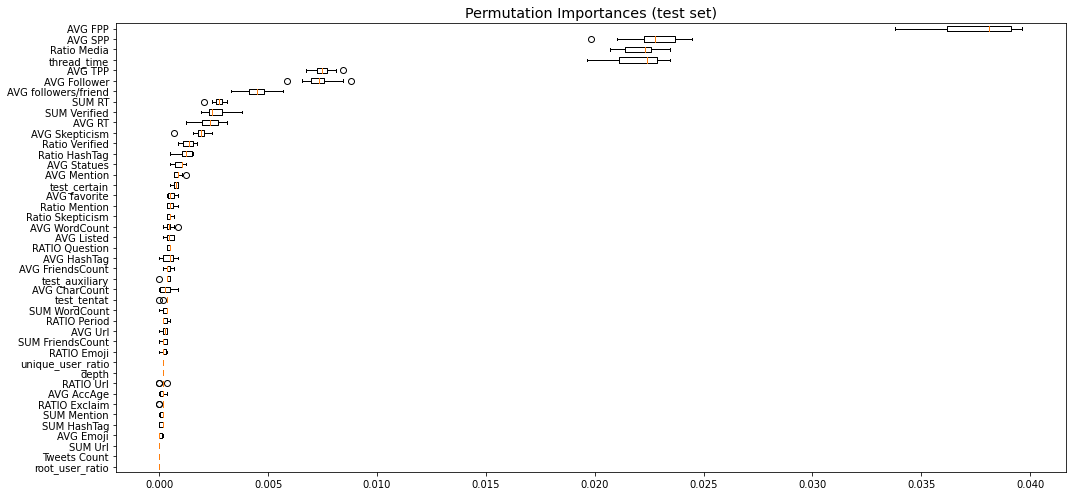

In [ ]:
f_imp2(pheme_thread_final, pheme_y)

# Sparse

In [508]:
scaler = StandardScaler()
pheme_scaled = pd.DataFrame(scaler.fit_transform(pheme_sparse_final))
ext_scaled = pd.DataFrame(scaler.transform(ext_sparse_final))

In [10]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_sparse_final.values, pheme_y, ext_sparse_final.values, ext_y)
# tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_scaled.values, pheme_y, ext_scaled.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(83378.6094), std: tensor(719914.0625)
torch.Size([5802, 1, 28]) torch.Size([485, 1, 28])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [11]:
class sparse_model(nn.Module):
    def __init__(self):
        super(sparse_model, self).__init__() # 1*20
        self.fc1 = nn.Linear(28, 6,bias=True)
        self.fc2 = nn.Linear(12, 8, bias=True)
        self.fc3 = nn.Linear(6, 1,bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = self.drop_2(x)
        # x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        # x = self.fc3(x)
        # x = self.fc3(x)
        return x

In [12]:
cv_pd_list = cv_rumor(model_sparse, pd.concat([pheme_sparse_final,pheme_event],axis=1))

NameError: name 'cv_rumor' is not defined

In [47]:
train_target = cv_pd_list[0][0].pop('target')
cv_pd_list[0][0]

,emoji_count,URLcount,has_media,Skepticism,MentionCount,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,test_auxiliary,test_tentat,test_certain,Numeral,char_count,word_count,HashTag,has_question,has_exclaim,has_period,capital_ratio,retweet_count,tweet_count,listed_count,friends_count,follower_count,followers/friend,favourites_count,account_age_days,verified,Event
0,0,2,1,4,0,0,0,0,1,0,0,0,133,16,1,0,0,1,0.105263,161,24950,2491,1873,115083,6.144314e+01,1.204120,1813,1,ferguson
1,0,0,0,3,0,0,0,0,1,0,0,0,80,13,1,0,0,0,0.025000,202,2871,91,606,3066,5.059406e+00,1.556303,1954,1,ferguson
2,0,1,0,4,0,0,0,1,0,0,0,1,124,18,1,0,0,1,0.024194,168,58842,7553,521,162748,3.123762e+02,0.778151,2288,1,ferguson
3,0,0,0,3,0,0,0,0,2,0,0,0,138,23,2,0,0,0,0.086957,446,118008,116,2590,3593,1.387259e+00,4.513471,2410,0,ferguson
4,0,1,0,4,0,0,0,1,0,0,0,1,124,18,1,0,0,1,0.056452,126,58842,7552,521,162744,3.123685e+02,0.778151,2289,1,ferguson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3718,0,2,1,3,0,1,1,0,1,0,0,0,103,10,1,0,0,1,0.116505,1716,3855,753,704,52008,7.387500e+01,3.147367,531,1,sydneysiege
3719,0,0,0,3,0,1,0,0,1,0,0,0,88,11,2,0,0,1,0.068182,1901,2927,7824,219,631082,2.881653e+03,0.477121,2713,1,sydneysiege
3720,0,1,0,8,0,0,0,1,1,0,0,0,126,17,1,0,1,1,0.039683,105,4799,84,32,36102,1.128188e+03,2.301030,549,0,sydneysiege
3721,0,1,0,1,0,0,0,0,0,0,0,0,121,17,0,0,0,1,0.107438,1237,22381,101782,3,12522565,4.174188e+06,-10.000000,2793,1,sydneysiege


In [57]:
print(cv_pd_list[0][0].values.shape)
print(train_target.shape)

(3723, 29)
(3723,)


In [95]:
def getDataSize(tensor_x1, tensor_y1, tensor_x2, tensor_y2):
    train_size = int(tensor_y1.size(0))
    test_size = int(tensor_y2.size(0))

    print("Variables)\n\tTrain:%s\n\tTest: %s"%(tensor_x1.size(),tensor_x2.size()))
    # print("\tTargets:%s \ %s"%(tensor_y1.size()[0],tensor_y2.size()[0]))
    print("Train Size",train_size,"Test Size",test_size)
    print()
    return train_size, test_size

In [114]:
# Class = {...}
model = sparse_model()
dataset = pheme_sparse_final


# ---------------------------------------------------------------------------- #
#                                INSIDE FUNCTION                               #
# ---------------------------------------------------------------------------- #

# cv_pd_list[?][0]은 Training cv_pd_list[?][1] Testing
cv_pd_list = []
data = pd.concat([dataset,pheme_event,pheme_y],axis=1)
NUM_EVENT = data.Event.unique().shape[0]
EVENTS = data.Event.unique()
for i, d in enumerate(EVENTS):
    df1, df2 = [x for _, x in data.groupby(data['Event'] != d)]
    df1.reset_index(inplace=True, drop=True)
    df2.reset_index(inplace=True, drop=True)
    cv_pd_list.append([df2, df1])


for train, test in cv_pd_list:
    print("Train: %s \ Test: %s" %(train.shape,test.shape))

print()

for index, fold in enumerate(cv_pd_list):
    train, test = fold

    # DATA PREPARATION
    print("Fold %d\n----------------------------------------------------------------------------" % (int(index)+1))
    
    train_target = train.pop('target')
    train.pop('Event')
    test_target = test.pop('target')
    test.pop('Event')

    # train, test = scaleData(train, test)

    tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(train.values, train_target, test.values, test_target.values)
    train_dataset = TensorDataset(tensor_x1,tensor_y1)
    test_dataset = TensorDataset(tensor_x2,tensor_y2)

    batch_size = 16

    train_sampler, test_sampler = __MLP.getSamplers(train_target, tensor_x2)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)

    data = next(iter(train_dataloader))
    print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

    train_size, test_size = getDataSize(tensor_x1, tensor_y1, tensor_x2, tensor_y2)

    epochs=100
    patience = 20

    # model_sparse = sparse_model()
    criterion = nn.BCEWithLogitsLoss()
    # optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
    # optimizer = optim.Adam(model_sparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-7)
    optimizer = AdamW(model.parameters(),
                        # lr=5e-5,    # Default learning rate
                        lr=5e-4,    # Default learning rate
                        eps=1e-8,    # Default epsilon value
                        weight_decay=1e-6
                        )

    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value
                                                num_training_steps=total_steps)

    PATH = "./Model/state_dict_sparse_fold_"+str(index+1)+".pt"
    print(PATH)

    # train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model, num_epochs=epochs, patience=patience, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

    


Train: (3723, 30) \ Test: (2079, 30)
Train: (4659, 30) \ Test: (1143, 30)
Train: (5333, 30) \ Test: (469, 30)
Train: (4912, 30) \ Test: (890, 30)
Train: (4581, 30) \ Test: (1221, 30)

Fold 1
----------------------------------------------------------------------------
mean: tensor(29070.3750), std: tensor(353242.9375)
Variables)
	Train:torch.Size([3723, 1, 28])
	Test: torch.Size([2079, 1, 28])
Train Size 3723 Test Size 2079

./Model/state_dict_sparse_fold_1.pt
Fold 2
----------------------------------------------------------------------------
mean: tensor(71985.6797), std: tensor(832315.)
Variables)
	Train:torch.Size([4659, 1, 28])
	Test: torch.Size([1143, 1, 28])
Train Size 4659 Test Size 1143

./Model/state_dict_sparse_fold_2.pt
Fold 3
----------------------------------------------------------------------------
mean: tensor(74294.3047), std: tensor(529107.8750)
Variables)
	Train:torch.Size([5333, 1, 28])
	Test: torch.Size([469, 1, 28])
Train Size 5333 Test Size 469

./Model/state_dict

In [644]:
def cv_rumor(model, data):
    for event in data.Event.unique():
        print(event)
    NUM_EVENT = data.Event.unique().shape[0]
    EVENTS = data.Event.unique()
    print(NUM_EVENT)
    print(EVENTS)
    cv_pd_list = []
    for i, d in enumerate(data.EVENTS):
        df1, df2 = [x for _, x in data.groupby(data['Event'] != d)]
        df1.reset_index(inplace=True, drop=True)
        df2.reset_index(inplace=True, drop=True)
        cv_pd_list.append([df1, df2])
    return cv_pd_list


# cv = __Preprocessing.cv_events(pd.concat([pheme_bert_simple, pheme_y, pheme_event],axis=1))
# X = cv[3][1].drop(['target', 'Event'],axis=1)
# y = cv[3][1].target
# val_X = cv[3][0].drop(['target', 'Event'],axis=1)
# val_y = cv[3][0].target

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_sparse_final.values, pheme_y, ext_sparse_final.values, ext_y)
# tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_scaled.values, pheme_y, ext_scaled.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))



mean: tensor(11374.9580), std: tensor(134097.6719)


In [632]:
epochs=100

model_sparse = sparse_model()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_sparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-7)
optimizer = AdamW(model_sparse.parameters(),
                    # lr=5e-5,    # Default learning rate
                    lr=5e-4,    # Default learning rate
                    eps=1e-8,    # Default epsilon value
                    weight_decay=1e-6
                    )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_sparse_model.pt"

In [513]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_sparse, num_epochs=epochs, patience=20, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.4871, Loss: 74397.0261
		Validation) Acc: 0.6062 Loss:759.0256
Epoch 2/99	Train) Acc: 0.4793, Loss: 41205.5738
		Validation) Acc: 0.6577 Loss:126.7176
Epoch 4/99	Train) Acc: 0.5457, Loss: 14457.8065
		Validation) Acc: 0.3897 Loss:10.8505
Epoch 6/99	Train) Acc: 0.5457, Loss: 6925.3089
		Validation) Acc: 0.2784 Loss:14.9174
			Saving the best model w/ val loss 3.1651
Epoch 8/99	Train) Acc: 0.5148, Loss: 303.6301
		Validation) Acc: 0.2433 Loss:1.4006
			Saving the best model w/ val loss 1.4006
			Saving the best model w/ val loss 1.1204
Epoch 10/99	Train) Acc: 0.4850, Loss: 76.1955
		Validation) Acc: 0.2412 Loss:0.8724
			Saving the best model w/ val loss 0.8724
			Saving the best model w/ val loss 0.8413
Epoch 12/99	Train) Acc: 0.5086, Loss: 3.1148
		Validation) Acc: 0.2412 Loss:0.8224
			Saving the best model w/ val loss 0.8224
			Saving the best model w/ val loss 0.8169
Epoch 14/99	Train) Acc: 0.5093, Loss: 1.5573
		Validation) Acc: 0.2412 Loss:0.8076
			Saving

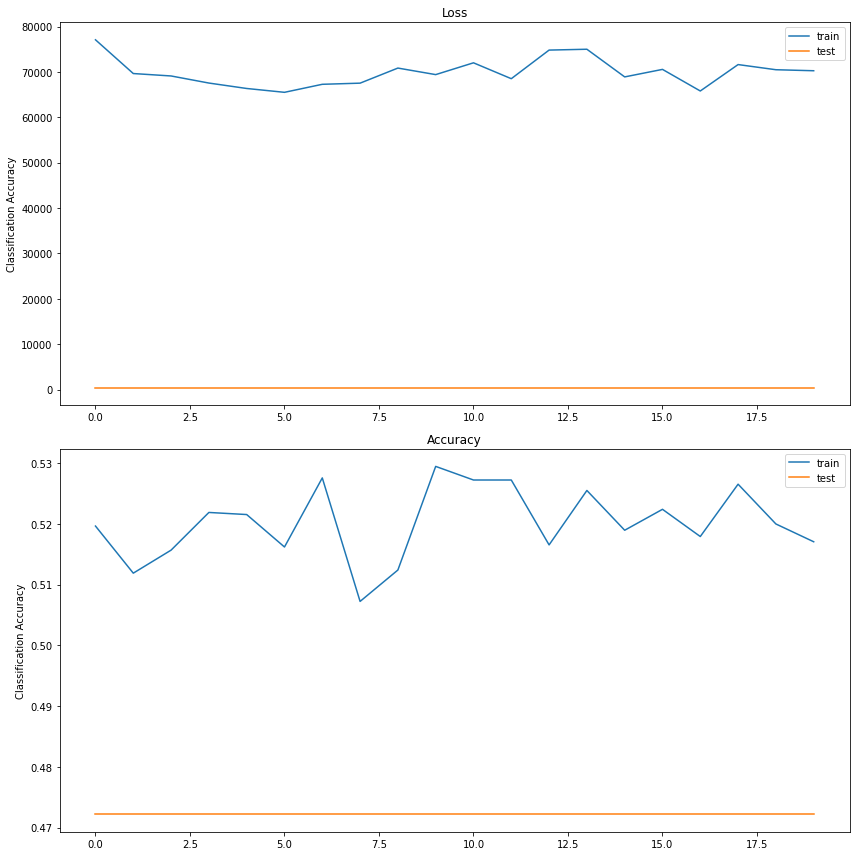

Min of Training Loss: 65505.340775
Max of Training Accuracy: 0.529473
Mean of Training Loss: 69910.801567
Mean of Training Accuracy: 0.520148
------------
Max of Testing Accuracy: 0.472165
Min of Testing Loss: 407.740909
Mean of Testing Loss: 407.740909
Mean of Testing Accuracy: 0.472165
------------


In [497]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [445]:
test_dataloader, test_size = test_data_process(ext_scaled, ext_y)

mean: tensor(-0.0001), std: tensor(0.9189)
Test Size 485


In [479]:
model = sparse_model()
PATH = './Model/state_dict_sparse_model.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model_sparse, criterion, test_dataloader, test_size)

accuracy_score:		0.2454
Precision Score:	1.0000
Recall Score:		0.0081
f1_score:		0.2357
Test_loss:		0.7108


# POS

In [397]:
scaler = StandardScaler()
pheme_scaled = pd.DataFrame(scaler.fit_transform(pheme_pos_final))
ext_scaled = pd.DataFrame(scaler.transform(ext_pos_final))

In [399]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_pos_final.values, pheme_y, ext_pos_final.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.7829), std: tensor(1.2603)
torch.Size([5802, 1, 19]) torch.Size([485, 1, 19])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [403]:
class pos_model(nn.Module):
    def __init__(self):
        super(pos_model, self).__init__() # 1*20
        self.fc1 = nn.Linear(19, 4,bias=True)
        # self.fc2 = nn.Linear(12, 8, bias=True)
        self.fc3 = nn.Linear(4, 1,bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = self.drop_2(x)
        # x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        # x = self.fc3(x)
        # x = self.fc3(x)
        return x

In [404]:
epochs=100

model_pos = pos_model()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_pos.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_pos_model.pt"

In [405]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_pos, num_epochs=epochs, patience=25, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.5100, Loss: 0.7008
		Validation) Acc: 0.2742 Loss:0.7768
			Saving the best model w/ val loss 0.7768
			Saving the best model w/ val loss 0.7507
Epoch 2/99	Train) Acc: 0.5629, Loss: 0.6864
		Validation) Acc: 0.3443 Loss:0.7320
			Saving the best model w/ val loss 0.7320
			Saving the best model w/ val loss 0.7269
Epoch 4/99	Train) Acc: 0.5851, Loss: 0.6776
		Validation) Acc: 0.4103 Loss:0.7170
			Saving the best model w/ val loss 0.7170
			Saving the best model w/ val loss 0.7154
Epoch 6/99	Train) Acc: 0.5901, Loss: 0.6762
		Validation) Acc: 0.4495 Loss:0.7145
			Saving the best model w/ val loss 0.7145
			Saving the best model w/ val loss 0.7081
Epoch 8/99	Train) Acc: 0.6003, Loss: 0.6696
		Validation) Acc: 0.5278 Loss:0.7014
			Saving the best model w/ val loss 0.7014
Epoch 10/99	Train) Acc: 0.6162, Loss: 0.6636
		Validation) Acc: 0.5299 Loss:0.7037
Epoch 12/99	Train) Acc: 0.6258, Loss: 0.6569
		Validation) Acc: 0.5361 Loss:0.7008
			Saving the best model w/ 

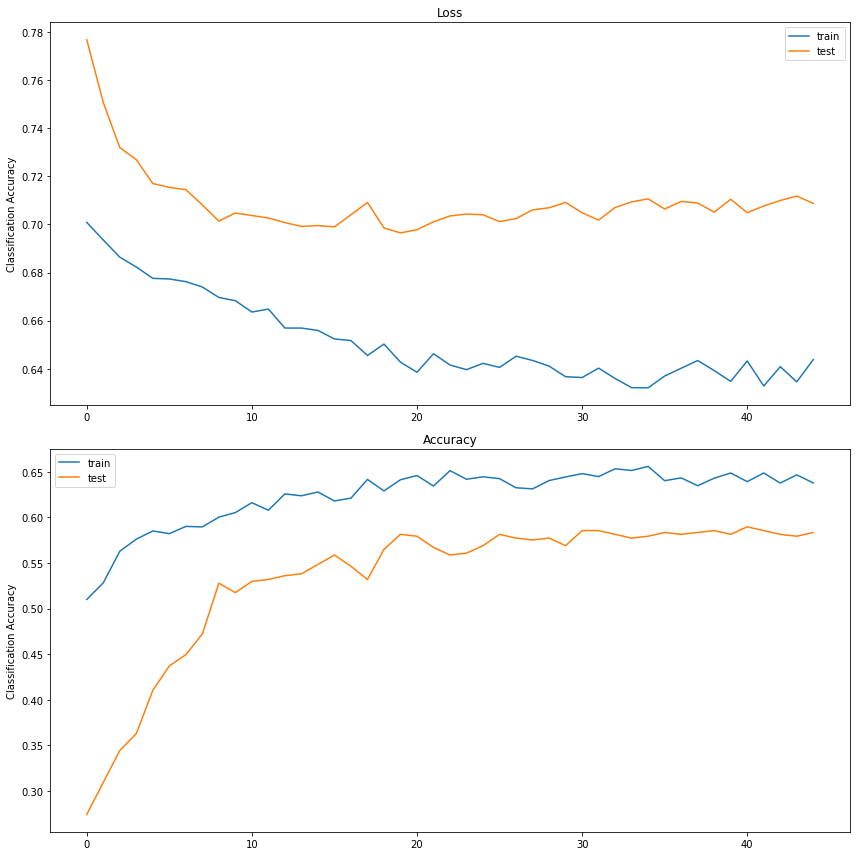

Min of Training Loss: 0.632085
Max of Training Accuracy: 0.655981
Mean of Training Loss: 0.651752
Mean of Training Accuracy: 0.623704
------------
Max of Testing Accuracy: 0.589691
Min of Testing Loss: 0.696476
Mean of Testing Loss: 0.709199
Mean of Testing Accuracy: 0.534066
------------


In [406]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [301]:
test_dataloader, test_size = test_data_process(ext_scaled, ext_y)

mean: tensor(-0.0001), std: tensor(0.9189)
Test Size 485


In [407]:
model = pos_model()
PATH = './Model/state_dict_pos_model.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.5814
Precision Score:	0.8705
Recall Score:		0.5285
f1_score:		0.5203
Test_loss:		0.6965


# W2V-MLP

In [112]:
pheme_AVGw2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_AVGw2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_AVGw2v,pheme_y,ext_AVGw2v,ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

torch.Size([5802, 1, 200]) torch.Size([485, 1, 200])
torch.Size([5802, 1]) torch.Size([485, 1])


In [113]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(-0.0187), std: tensor(0.2649)
torch.Size([5802, 1, 200]) torch.Size([485, 1, 200])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [131]:
class W2V_net(nn.Module):
    def __init__(self):
        super(W2V_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(200, 12, bias=True) # 420
        # self.fc2 = nn.Linear(12, 1, bias=True)
        self.fc3 = nn.Linear(12, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.F.elu(self.fc1(x))
        # x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [132]:
model_w2v = W2V_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(task1_model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_w2v.parameters(), lr=5e-5, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

train_loss = []
train_accuracy = []

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_w2v_model.pt"

In [133]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_w2v, num_epochs=100, patience=20, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


AttributeError: 'W2V_net' object has no attribute 'F'

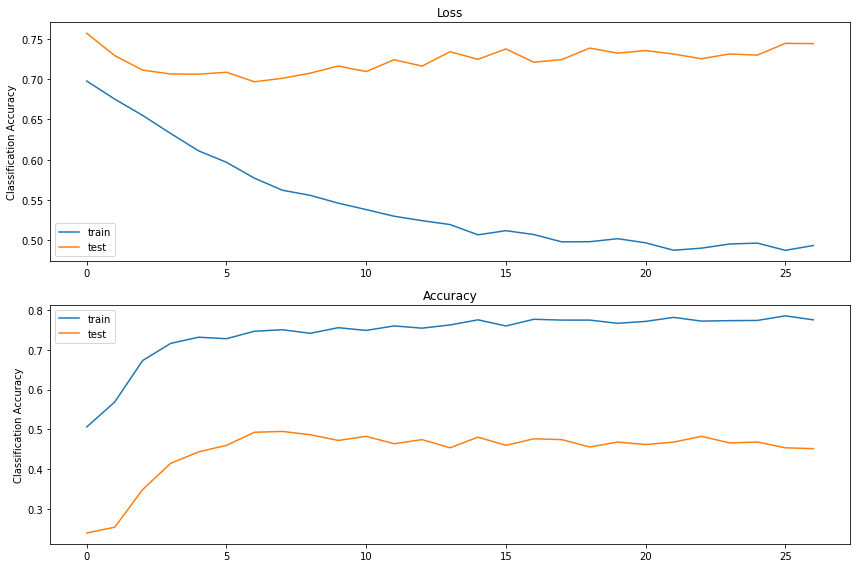

Min of Training Loss: 0.487520
Max of Training Accuracy: 0.785936
Mean of Training Loss: 0.544180
Mean of Training Accuracy: 0.741398
------------
Max of Testing Accuracy: 0.494845
Min of Testing Loss: 0.696725
Mean of Testing Loss: 0.723822
Mean of Testing Accuracy: 0.446124
------------


In [124]:
clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [134]:
model = W2V_net()
PATH = './Model/state_dict_w2v_model.pt'
model.load_state_dict(torch.load(PATH))
predict(model, criterion, test_dataloader, test_size)

AttributeError: 'W2V_net' object has no attribute 'F'

# BERT

In [621]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_simple_normal.values, pheme_y, ext_bert_simple_normal.values, ext_y)
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_brackets_normal.values, pheme_y, ext_bert_brackets_normal.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0398), std: tensor(0.3303)
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [622]:
class BERT_net(nn.Module):
    def __init__(self):
        super(BERT_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(768, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

In [626]:
epochs = 100
model_bert = BERT_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
optimizer = AdamW(model_bert.parameters(),
                    # lr=5e-5,    # Default learning rate
                    lr=5e-5,    # Default learning rate
                    eps=1e-8,    # Default epsilon value
                    weight_decay=1e-6
                    )
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model.pt"

In [627]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=epochs, patience=25, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.7597, Loss: 0.4974
		Validation) Acc: 0.3629 Loss:1.0739
			Saving the best model w/ val loss 1.0739
			Saving the best model w/ val loss 0.7358
Epoch 2/99	Train) Acc: 0.8151, Loss: 0.4189
		Validation) Acc: 0.5835 Loss:0.7861
Epoch 4/99	Train) Acc: 0.8149, Loss: 0.4241
		Validation) Acc: 0.6062 Loss:0.8127
Epoch 6/99	Train) Acc: 0.8270, Loss: 0.3893
		Validation) Acc: 0.6784 Loss:0.7018
			Saving the best model w/ val loss 0.7018
Epoch 8/99	Train) Acc: 0.8182, Loss: 0.3977
		Validation) Acc: 0.5814 Loss:0.8917
Epoch 10/99	Train) Acc: 0.8290, Loss: 0.3693
		Validation) Acc: 0.7072 Loss:0.7048
Epoch 12/99	Train) Acc: 0.8335, Loss: 0.3688
		Validation) Acc: 0.6598 Loss:0.7604
Epoch 14/99	Train) Acc: 0.8366, Loss: 0.3577
		Validation) Acc: 0.5608 Loss:1.0941
Epoch 16/99	Train) Acc: 0.8326, Loss: 0.3536
		Validation) Acc: 0.7237 Loss:0.7048
Epoch 18/99	Train) Acc: 0.8352, Loss: 0.3497
		Validation) Acc: 0.6371 Loss:0.9081
Epoch 20/99	Train) Acc: 0.8433, Loss: 0.339

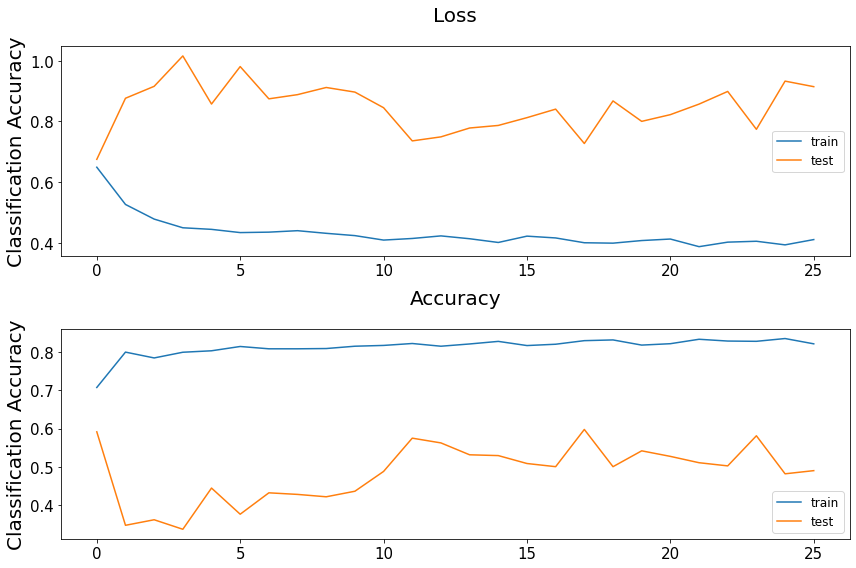

Min of Training Loss: 0.387909
Max of Training Accuracy: 0.834540
Mean of Training Loss: 0.432381
Mean of Training Accuracy: 0.812406
------------
Max of Testing Accuracy: 0.597938
Min of Testing Loss: 0.675329
Mean of Testing Loss: 0.847569
Mean of Testing Accuracy: 0.485488
------------


In [509]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [511]:
model = BERT_net()
PATH = './Model/state_dict_bert_model.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.5918
Precision Score:	0.8800
Recall Score:		0.5366
f1_score:		0.5795
Test_loss:		0.6753


# Thread

In [491]:
cv = __Preprocessing.cv_events(pd.concat([pheme_thread_final_std, pheme_y, pheme_event],axis=1))
X = cv[3][1].drop(['target', 'Event'],axis=1)
y = cv[3][1].target
val_X = cv[3][0].drop(['target', 'Event'],axis=1)
val_y = cv[3][0].target

In [512]:
scaler = StandardScaler()
pheme_thread_scaled = pd.DataFrame(scaler.fit_transform(pheme_thread_final_avg))
ext_thread_scaled = pd.DataFrame(scaler.transform(ext_thread_final_avg))


In [631]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_thread_final_avg.values, pheme_y, ext_thread_final_avg.values, ext_y)
# tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_thread_scaled.values, pheme_y, ext_thread_scaled.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(1479.9050), std: tensor(6991.4272)
torch.Size([5802, 1, 52]) torch.Size([485, 1, 52])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [632]:
class thread_model(nn.Module):
    def __init__(self):
        super(thread_model, self).__init__() # 1*20
        self.fc1 = nn.Linear(52, 8, bias=True) # 420
        # self.fc2 = nn.Linear(12, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_4(F.elu(self.fc1(x)))
        # x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

In [633]:
epochs=100
model_thread = thread_model()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_thread.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
optimizer = AdamW(model_thread.parameters(),
                    # lr=5e-5,    # Default learning rate
                    lr=5e-5,    # Default learning rate
                    eps=1e-8,    # Default epsilon value
                    weight_decay=1e-6
                    )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_thread_model.pt"

In [634]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_thread, num_epochs=epochs, patience=35, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.4867, Loss: 1868.5007
		Validation) Acc: 0.5072 Loss:71.9902
Epoch 2/99	Train) Acc: 0.5217, Loss: 652.1549
		Validation) Acc: 0.4536 Loss:86.4131
Epoch 4/99	Train) Acc: 0.5305, Loss: 395.6629
		Validation) Acc: 0.4701 Loss:52.8809
Epoch 6/99	Train) Acc: 0.5379, Loss: 260.5215
		Validation) Acc: 0.5959 Loss:18.0672
Epoch 8/99	Train) Acc: 0.5390, Loss: 149.0776
		Validation) Acc: 0.5856 Loss:9.0022
			Saving the best model w/ val loss 9.0022
			Saving the best model w/ val loss 7.2387
Epoch 10/99	Train) Acc: 0.5419, Loss: 130.3084
		Validation) Acc: 0.6598 Loss:5.8316
			Saving the best model w/ val loss 5.8316
			Saving the best model w/ val loss 4.6466
Epoch 12/99	Train) Acc: 0.5259, Loss: 83.5610
		Validation) Acc: 0.6598 Loss:3.5526
			Saving the best model w/ val loss 3.5526
			Saving the best model w/ val loss 3.5001
Epoch 14/99	Train) Acc: 0.5212, Loss: 26.0952
		Validation) Acc: 0.6309 Loss:3.4567
			Saving the best model w/ val loss 3.4567
			Saving the 

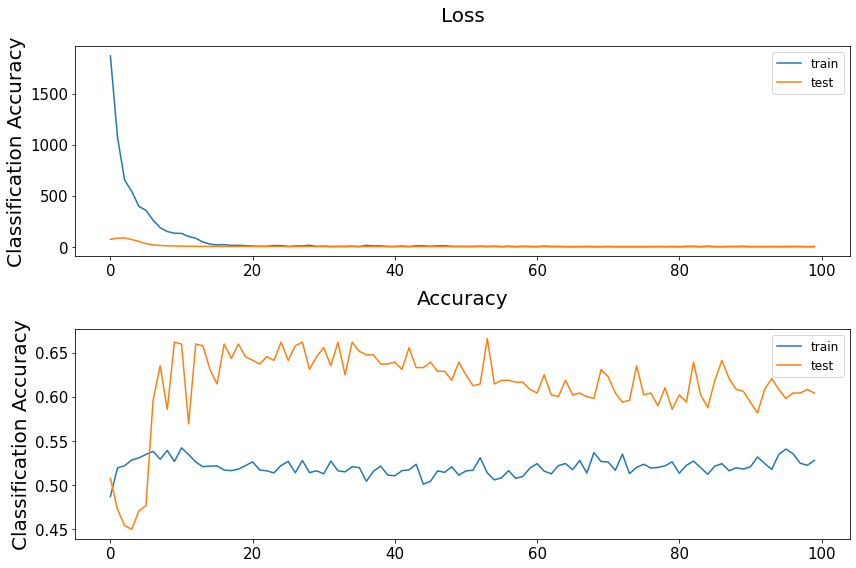

Min of Training Loss: 0.692108
Max of Training Accuracy: 0.541882
Mean of Training Loss: 63.533100
Mean of Training Accuracy: 0.520233
------------
Max of Testing Accuracy: 0.665979
Min of Testing Loss: 1.084083
Mean of Testing Loss: 5.977689
Mean of Testing Accuracy: 0.614660
------------


In [635]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [563]:
model = thread_model()
PATH = './Model/state_dict_thread_model.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.7361
Precision Score:	0.7603
Recall Score:		0.9539
f1_score:		0.7468
Test_loss:		0.9134


# SPARSE + THREAD

In [580]:
tensor_x2.size()
tensor_y2.size()
tensor_x1.size()
tensor_y1.size()

torch.Size([5802, 1])

In [595]:
pheme_temp

,emoji_count,URLcount,has_media,Skepticism,MentionCount,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,test_auxiliary,test_tentat,test_certain,Numeral,char_count,word_count,HashTag,has_question,has_exclaim,has_period,capital_ratio,retweet_count,tweet_count,listed_count,friends_count,follower_count,followers/friend,favourites_count,account_age_days,verified,!,#,&,",",@,^,a,d,g,l,n,o,p,r,s,t,u,v,x,z,~
0,0,1,0,4,0,0,0,0,0,0,0,0,88,12,0,0,0,1,0.159091,177,63575,7177,614,193798,3.156319e+02,1.886491,2126,1,0,0,0,1,0,1,2,0,0,0,5,0,2,0,0,0,1,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,53,6,1,0,0,1,0.037736,134,1076,140,375,4709,1.255733e+01,-10.000000,1050,0,0,1,0,2,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0
2,0,0,0,3,0,0,0,0,1,0,0,0,136,18,2,0,0,1,0.073529,148,7182,758,592,20401,3.446115e+01,2.173186,2030,0,0,0,0,5,0,6,3,0,0,0,3,0,2,1,0,0,0,3,0,0,0
3,0,2,0,8,0,0,0,0,2,0,0,0,138,16,1,0,0,1,0.101449,684,54427,102287,1038,15405096,1.484113e+04,2.952792,2891,1,0,0,0,1,0,2,0,2,0,0,1,0,1,1,0,0,2,7,0,0,0
4,0,2,1,3,0,0,0,0,0,0,0,0,117,13,1,0,0,1,0.145299,113,104998,13583,460,842236,1.830948e+03,1.414973,1975,1,0,0,0,1,0,3,1,0,0,0,5,0,2,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,0,2,1,3,0,1,1,0,1,0,0,0,103,10,1,0,0,1,0.116505,1716,3855,753,704,52008,7.387500e+01,3.147367,531,1,0,0,0,2,0,2,0,0,0,1,0,1,2,0,0,0,2,2,0,0,0
5798,0,0,0,3,0,1,0,0,1,0,0,0,88,11,2,0,0,1,0.068182,1901,2927,7824,219,631082,2.881653e+03,0.477121,2713,1,0,2,1,1,0,0,1,1,0,0,3,0,1,0,0,0,0,1,0,1,0
5799,0,1,0,8,0,0,0,1,1,0,0,0,126,17,1,0,1,1,0.039683,105,4799,84,32,36102,1.128188e+03,2.301030,549,0,0,1,1,1,0,0,3,4,0,0,2,1,1,0,0,0,1,3,0,0,0
5800,0,1,0,1,0,0,0,0,0,0,0,0,121,17,0,0,0,1,0.107438,1237,22381,101782,3,12522565,4.174188e+06,-10.000000,2793,1,0,0,0,1,0,3,2,1,0,0,6,0,3,0,0,0,1,1,0,0,0


In [637]:
scaler = StandardScaler()
pheme_temp = scaler.fit_transform(pd.concat([pheme_sparse_final, pheme_pos_final],axis=1))
ext_temp = scaler.transform(pd.concat([ext_sparse_final, ext_pos_final],axis=1))

pheme_temp = pd.concat([pheme_sparse_final, pheme_pos_final],axis=1)
ext_temp = pd.concat([ext_sparse_final, ext_pos_final],axis=1)

# pheme_sparse_bert_spread = pd.concat([pheme_sparse, pheme_thread, pheme_bert],axis=1)
# ext_sparse_bert_spread = pd.concat([ext_sparse, ext_thread_log, ext_bert],axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_temp.values, pheme_y, ext_temp.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(63328.6523), std: tensor(819896.0625)
torch.Size([5802, 1, 49]) torch.Size([485, 1, 49])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [638]:
class sparse_pos_net(nn.Module):
    def __init__(self):
        super(sparse_pos_net, self).__init__()  # 1*20
        self.fc1 = nn.Linear(49, 6, bias=True)  # 420
        # self.fc2 = nn.Linear(12, 7, bias=True)
        self.fc3 = nn.Linear(6, 1, bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_5 = nn.Dropout(0.5)
        self.drop_2 = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        # x = F.elu(self.fc1(x))
        x = F.elu(self.fc3(x))
        # x = F.elu(self.fc2(x))
        # x = self.fc3(x)
        return x


In [642]:
__MLP.set_seed(42)
model_sparse_pos = sparse_pos_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_sparse_pos.parameters(), lr=8e-3,eps=1e-8, weight_decay=1e-4)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
optimizer = AdamW(model_sparse_pos.parameters(),
                    lr=5e-5,    # Default learning rate
                    eps=1e-8,    # Default epsilon value
                    weight_decay=1e-6
                    )
train_loss = []
train_accuracy = []

epochs = 100

PATH = "./Model/state_dict_sparse_pos_model.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [643]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_sparse_pos, num_epochs=epochs, patience=99, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.5384, Loss: 219.9377
		Validation) Acc: 0.2454 Loss:1.0668
			Saving the best model w/ val loss 1.0668
Epoch 2/99	Train) Acc: 0.6346, Loss: 22.2922
		Validation) Acc: 0.2433 Loss:1.0690
Epoch 4/99	Train) Acc: 0.6494, Loss: 11.0682
		Validation) Acc: 0.2412 Loss:1.0726
Epoch 6/99	Train) Acc: 0.6484, Loss: 8.5002
		Validation) Acc: 0.2412 Loss:1.0726
Epoch 8/99	Train) Acc: 0.6499, Loss: 13.2063
		Validation) Acc: 0.2412 Loss:1.0726
Epoch 10/99	Train) Acc: 0.6543, Loss: 3.1172
		Validation) Acc: 0.2412 Loss:1.0726
Epoch 12/99	Train) Acc: 0.6560, Loss: 3.6667
		Validation) Acc: 0.2412 Loss:1.0726
Epoch 14/99	Train) Acc: 0.6518, Loss: 2.5881
		Validation) Acc: 0.2412 Loss:1.0725
Epoch 16/99	Train) Acc: 0.6544, Loss: 2.2444
		Validation) Acc: 0.2392 Loss:1.0728
Epoch 18/99	Train) Acc: 0.6544, Loss: 1.3933
		Validation) Acc: 0.2392 Loss:1.0732
Epoch 20/99	Train) Acc: 0.6555, Loss: 1.2651
		Validation) Acc: 0.2392 Loss:1.0737
Epoch 22/99	Train) Acc: 0.6565, Loss: 1.514

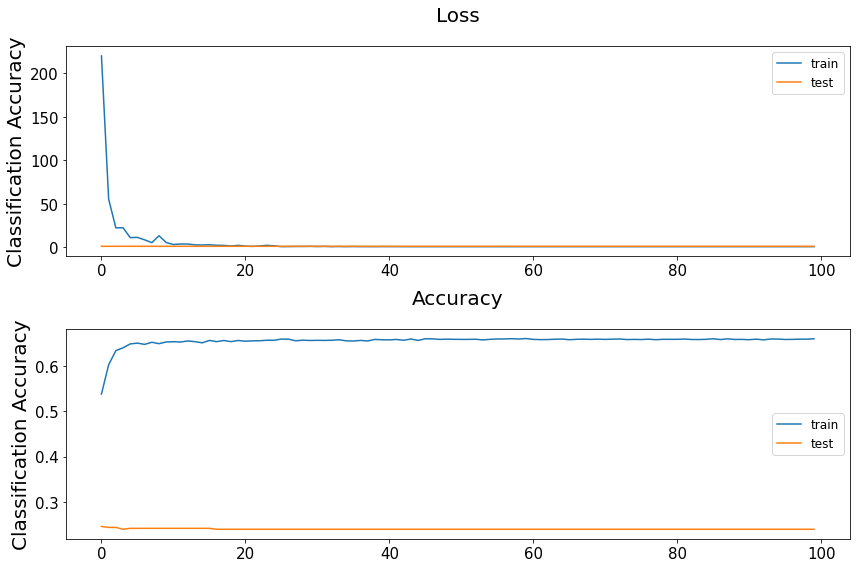

Min of Training Loss: 0.650778
Max of Training Accuracy: 0.661324
Mean of Training Loss: 4.597354
Mean of Training Accuracy: 0.655979
------------
Max of Testing Accuracy: 0.245361
Min of Testing Loss: 1.066846
Mean of Testing Loss: 1.073609
Mean of Testing Accuracy: 0.239567
------------


In [644]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [ ]:
model = sparse_pos_net()
PATH = './Model/state_dict_sparse_pos_model.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.5320
Precision Score:	0.9128
Recall Score:		0.4255
f1_score:		0.5426
Test_loss:		0.6983


# Sparse + POS + Thread

In [442]:
# scaler = StandardScaler()
pheme_temp = scaler.fit_transform(pd.concat([pheme_sparse_final, pheme_pos_final, pheme_thread_final_avg],axis=1))
ext_temp = scaler.transform(pd.concat([ext_sparse_final, ext_pos_final, ext_thread_final_avg],axis=1))
# pheme_temp = pd.concat([pheme_sparse_final, pheme_pos_final, pheme_thread_final_avg],axis=1)
# ext_temp = pd.concat([ext_sparse_final, ext_pos_final, ext_thread_final_avg],axis=1)

# pheme_sparse_bert_spread = pd.concat([pheme_sparse, pheme_thread, pheme_bert],axis=1)
# ext_sparse_bert_spread = pd.concat([ext_sparse, ext_thread_log, ext_bert],axis=1)

# tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_temp.values, pheme_y, ext_temp.values, ext_y)
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_temp, pheme_y, ext_temp, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(-0.0490), std: tensor(0.7427)
torch.Size([5802, 1, 99]) torch.Size([485, 1, 99])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [443]:
class sparse_pos_thread_net(nn.Module):
    def __init__(self):
        super(sparse_pos_thread_net, self).__init__()  # 1*20
        self.fc1 = nn.Linear(99, 8, bias=True)  # 420
        # self.fc2 = nn.Linear(36, 8, bias=True)
        self.fc3 = nn.Linear(8, 1, bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_5 = nn.Dropout(0.5)
        self.drop_2 = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.drop_3(F.elu(self.fc1(x)))
        # x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        # x = F.elu(self.fc2(x))
        # x = self.fc3(x)
        return x


In [438]:
__MLP.set_seed(42)
model_sparse_pos_thread = sparse_pos_thread_net()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# optimizer = optim.Adam(model_sparse_pos_thread.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# optimizer = AdamW(model_sparse_pos.parameters(),
                    # lr=5e-5,    # Default learning rate
                    # eps=1e-8,    # Default epsilon value
                    # weight_decay=1e-6
                    # )
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 50

PATH = "./Model/state_dict_sparse_pos_thread_model.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [439]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_sparse_pos_thread, num_epochs=epochs, patience=25, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/49	Train) Acc: 0.4959, Loss: 0.7169
		Validation) Acc: 0.7196 Loss:0.6406
			Saving the best model w/ val loss 0.6406
Epoch 2/49	Train) Acc: 0.5028, Loss: 0.7116
		Validation) Acc: 0.7196 Loss:0.6406
Epoch 4/49	Train) Acc: 0.4864, Loss: 0.7197
		Validation) Acc: 0.7196 Loss:0.6406
Epoch 6/49	Train) Acc: 0.4969, Loss: 0.7165
		Validation) Acc: 0.7196 Loss:0.6406
Epoch 8/49	Train) Acc: 0.5033, Loss: 0.7142
		Validation) Acc: 0.7196 Loss:0.6406
Epoch 10/49	Train) Acc: 0.5059, Loss: 0.7138
		Validation) Acc: 0.7196 Loss:0.6406
Epoch 12/49	Train) Acc: 0.5019, Loss: 0.7162
		Validation) Acc: 0.7196 Loss:0.6406
Epoch 14/49	Train) Acc: 0.5010, Loss: 0.7140
		Validation) Acc: 0.7196 Loss:0.6406
Epoch 16/49	Train) Acc: 0.4976, Loss: 0.7163
		Validation) Acc: 0.7196 Loss:0.6406
Epoch 18/49	Train) Acc: 0.5029, Loss: 0.7160
		Validation) Acc: 0.7196 Loss:0.6406
Epoch 20/49	Train) Acc: 0.4859, Loss: 0.7198
		Validation) Acc: 0.7196 Loss:0.6406
Epoch 22/49	Train) Acc: 0.4898, Loss: 0.7185
		V

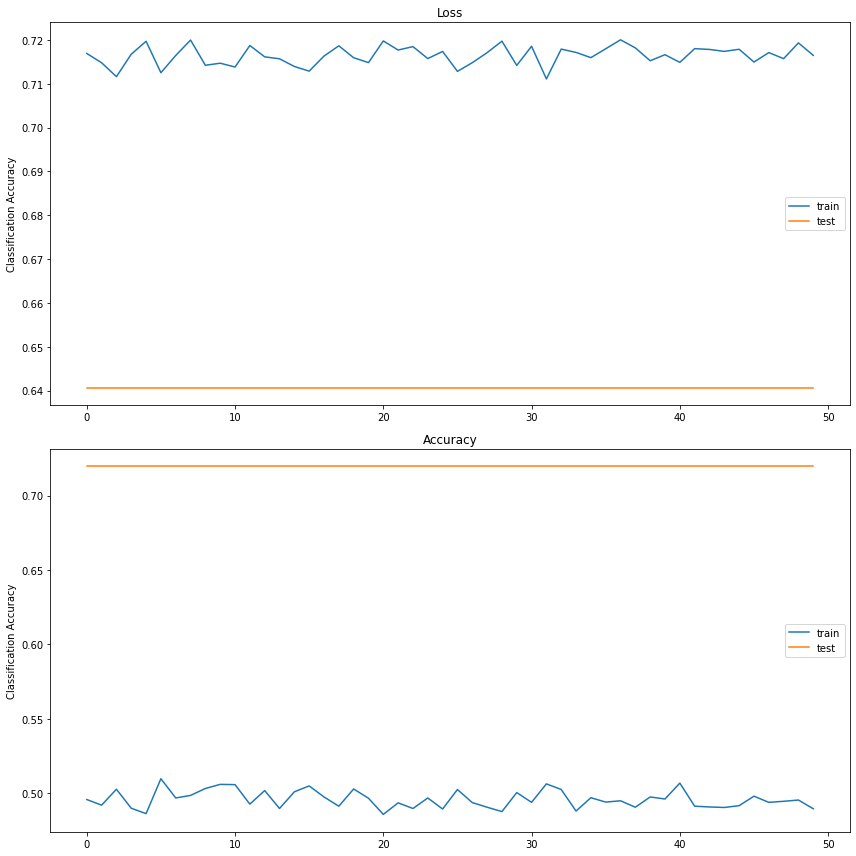

Min of Training Loss: 0.711116
Max of Training Accuracy: 0.509824
Mean of Training Loss: 0.716425
Mean of Training Accuracy: 0.496057
------------
Max of Testing Accuracy: 0.719588
Min of Testing Loss: 0.640628
Mean of Testing Loss: 0.640628
Mean of Testing Accuracy: 0.719588
------------


In [440]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [441]:
model = sparse_pos_thread_net()
PATH = './Model/state_dict_sparse_pos_thread_model.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.7196
Precision Score:	0.7642
Recall Score:		0.9133
f1_score:		0.7292
Test_loss:		0.6406


# Sparse + W2V -> MLP

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pheme_sparse = scaler.fit_transform(pheme_sparse.values)
sparse_bert = np.concatenate([pheme_sparse, pheme_bert.values],axis=1)
ext_sparse = scaler.fit_transform(ext_sparse.values)
sparse_bert_ext = np.concatenate([ext_sparse, ext_bert.values],axis=1)

tensor_x1 = torch.Tensor(sparse_bert).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(sparse_bert_ext).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [36]:
pheme_sparse_W2V = pd.concat([pheme_sparse, pheme_AVGw2v],axis=1)
ext_sparse_W2V = pd.concat([ext_sparse, ext_AVGw2v],axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_sparse_W2V, pheme_y, ext_sparse_W2V, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [59]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(10.0300), std: tensor(133.5756)
torch.Size([5802, 1, 229]) torch.Size([485, 1, 229])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [60]:
class W2V_sparse_net(nn.Module):
    def __init__(self):
        super(W2V_sparse_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(229, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1,bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [61]:
set_seed(42)
model_w2vsparse = W2V_sparse_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_w2vsparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_w2v_sparse_model.pt"

In [63]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_w2vsparse, num_epochs=40, patience=8, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/39	Train) Acc: 0.4964, Loss: 1.1619
		Validation) Acc: 0.4103 Loss:0.8039
		Saving the best model w/ loss 1.1619
		Saving the best model w/ loss 0.8770
Epoch 2/39	Train) Acc: 0.4883, Loss: 0.9466
		Validation) Acc: 0.7443 Loss:0.7230
		Saving the best model w/ loss 0.8220
Epoch 4/39	Train) Acc: 0.4831, Loss: 0.8286
		Validation) Acc: 0.7505 Loss:0.7036
		Saving the best model w/ loss 0.7546
Epoch 6/39	Train) Acc: 0.5019, Loss: 0.8223
		Validation) Acc: 0.7526 Loss:0.7055
Epoch 8/39	Train) Acc: 0.5009, Loss: 0.8449
		Validation) Acc: 0.7526 Loss:0.6902
		Saving the best model w/ loss 0.7223
Epoch 10/39	Train) Acc: 0.5160, Loss: 0.7300
		Validation) Acc: 0.7546 Loss:0.6764
Epoch 12/39	Train) Acc: 0.4995, Loss: 0.7305
		Validation) Acc: 0.7546 Loss:0.6784
		Saving the best model w/ loss 0.7204
Epoch 14/39	Train) Acc: 0.5093, Loss: 0.7425
		Validation) Acc: 0.7546 Loss:0.6702
		Saving the best model w/ loss 0.7117
Epoch 16/39	Train) Acc: 0.5050, Loss: 0.7084
		Validation) Acc: 0.75

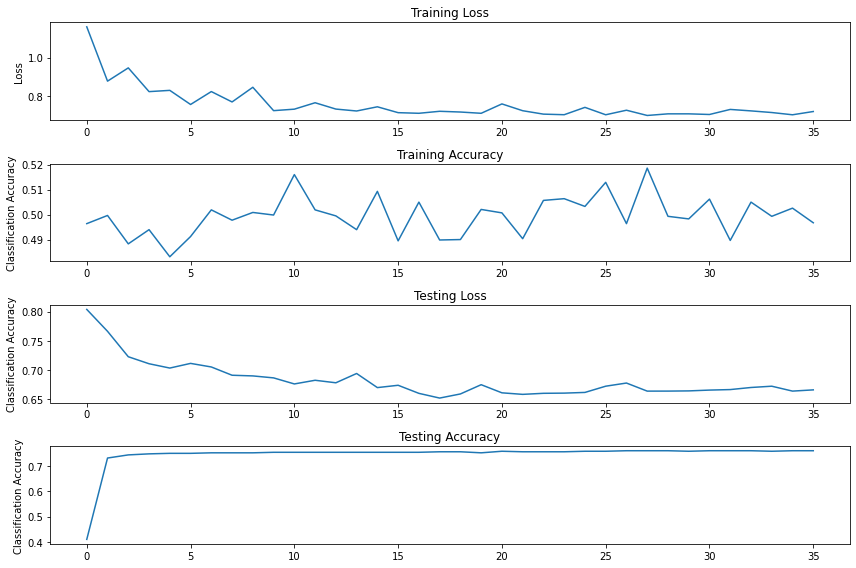

Min of Training Loss: 0.696975
Max of Training Accuracy: 0.518614
Mean of Training Loss: 0.756582
Mean of Training Accuracy: 0.499483
----
Max of Testing Accuracy: 0.760825
Mean of Testing Loss: 0.682468
Mean of Testing Accuracy: 0.745762


In [65]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

# Sparse + BERT -> MLP

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pheme_sparse = scaler.fit_transform(pheme_sparse.values)
sparse_bert = np.concatenate([pheme_sparse, pheme_bert_bracket.values],axis=1)
ext_sparse = scaler.fit_transform(ext_sparse.values)
sparse_bert_ext = np.concatenate([ext_sparse, ext_bert_bracket.values],axis=1)

In [10]:
# pheme_sparse_bert = pd.concat([pheme_sparse, pheme_bert],axis=1)
# ext_sparse_bert = pd.concat([ext_sparse, ext_bert],axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(sparse_bert, pheme_y, sparse_bert_ext, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

torch.Size([5802, 1, 804]) torch.Size([485, 1, 804])
torch.Size([5802, 1]) torch.Size([485, 1])


In [11]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0374), std: tensor(0.3707)
torch.Size([5802, 1, 804]) torch.Size([485, 1, 804])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [12]:
class BERT_sparse_net(nn.Module):
    def __init__(self):
        super(BERT_sparse_net, self).__init__()  # 1*20
        self.fc1 = nn.Linear(804, 96, bias=True)  # 420
        self.fc2 = nn.Linear(96, 12, bias=True)
        self.fc3 = nn.Linear(12, 1, bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_1 = nn.Dropout(0.1)
        self.drop_2 = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.drop_3(F.elu(self.fc1(x)))
        x = self.drop_3(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [14]:
__MLP.set_seed(42)
model_bertsparse = BERT_sparse_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparse.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 40

PATH = "./Model/state_dict_bert_sparse_model.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [15]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bertsparse, num_epochs=40, patience=10, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/39	Train) Acc: 0.6394, Loss: 0.6699
		Validation) Acc: 0.6000 Loss:0.6820
			Saving the best model w/ val loss 0.6820
Epoch 2/39	Train) Acc: 0.7630, Loss: 0.5373
		Validation) Acc: 0.4392 Loss:0.7909
Epoch 4/39	Train) Acc: 0.7897, Loss: 0.4813
		Validation) Acc: 0.4722 Loss:0.8149
Epoch 6/39	Train) Acc: 0.8085, Loss: 0.4524
		Validation) Acc: 0.4990 Loss:0.7807
Epoch 8/39	Train) Acc: 0.8051, Loss: 0.4510
		Validation) Acc: 0.4845 Loss:0.8177
Epoch 10/39	Train) Acc: 0.8046, Loss: 0.4474
		Validation) Acc: 0.4680 Loss:0.8614
Finishing the Model: Val Loss is not decreasing...
[0.8267497191109608, 0.7807256255567688, 0.909077041419511, 0.8176943631516289, 0.8578154425031131]


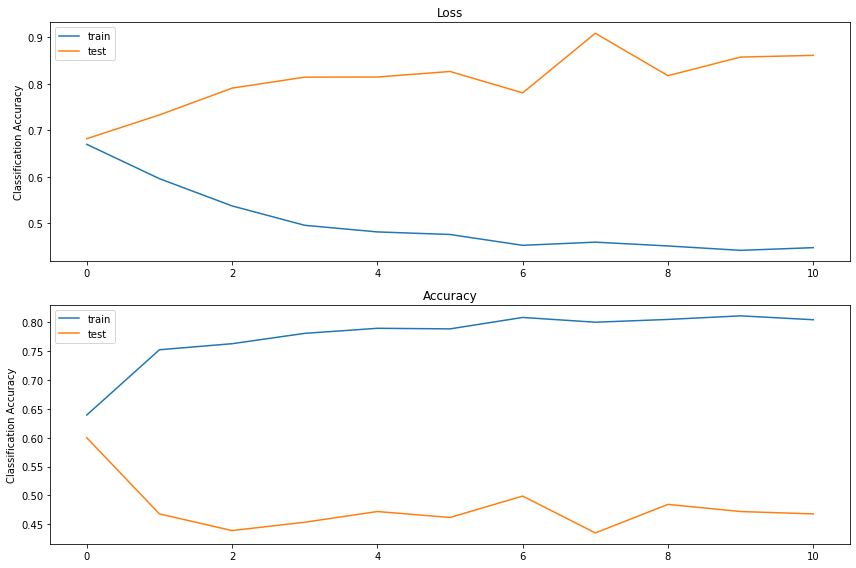

Min of Training Loss: 0.441590
Max of Training Accuracy: 0.811272
Mean of Training Loss: 0.500658
Mean of Training Accuracy: 0.776723
------------
Max of Testing Accuracy: 0.600000
Min of Testing Loss: 0.682040
Mean of Testing Loss: 0.808098
Mean of Testing Accuracy: 0.477601
------------


In [16]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

# Sparse + BERT -> MLP (Multi)

In [604]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# pheme_scaled = scaler.fit_transform(np.concatenate([pheme_sparse.values, pheme_thread.values],axis=1))
pheme_sparse_scaled = pd.DataFrame(scaler.fit_transform(pheme_sparse))
# Train = np.concatenate([train, pheme_bert.values],axis=1)

ext_sparse_scaled = pd.DataFrame(scaler.transform(ext_sparse))
# Test = np.concatenate([test, ext_bert.values],axis=1)

In [11]:
# tensor_x11 = torch.Tensor(pheme_scaled).unsqueeze(1)
tensor_x11 = torch.Tensor(pheme_sparse_scaled.values).unsqueeze(1)
tensor_x12 = torch.Tensor(pheme_bert.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x11, tensor_x12, tensor_y1)

tensor_x21 = torch.Tensor(ext_sparse_scaled.values).unsqueeze(1)
# tensor_x21 = torch.Tensor(ext_sparse_scaled).unsqueeze(1)
tensor_x22 = torch.Tensor(ext_bert.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x21, tensor_x22, tensor_y2)


In [83]:
# tensor_x11, tensor_x12, tensor_y1, tensor_x21, tensor_x22, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_sparse, pheme_y, ext_sparse, ext_y, pheme_bert, ext_bert)
# train_dataset = TensorDataset(tensor_x11, tensor_x12, tensor_y1)
# test_dataset = TensorDataset(tensor_x21, tensor_x22, tensor_y2)

In [12]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x21)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x11.shape,tensor_x21.shape)
print(tensor_x12.shape,tensor_x22.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(-0.0314), std: tensor(0.9928)
torch.Size([5802, 1, 36]) torch.Size([485, 1, 36])
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [13]:
class BERT_sparse_net_multi(nn.Module):
    def __init__(self):
        super(BERT_sparse_net_multi, self).__init__()  # 1*20

        self.layer1 = nn.Sequential(
            nn.Linear(36, 5, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(5, 2, bias=True),  # 420
        )
        self.layer2 = nn.Sequential(
            nn.Linear(768, 64, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 8, bias=True),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(10, 1)  # 420
        )

        self.drop_2 = nn.Dropout(0.2)

    def forward(self, sparse, embedding):
        x1 = self.layer1(sparse)
        x2 = self.layer2(embedding)
        
        x = torch.cat((x1.squeeze(1), x2.squeeze(1)), dim=1)
        x = self.layer3(x)
        return x

In [14]:
# _MLP.set_seed(42)
model_bertsparse_multi = BERT_sparse_net_multi()
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparse_multi.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 40

PATH = "./Model/state_dict_bert_sparse_multi.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [15]:
def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_sparse, val_embedding, val_labels = val
            val_sparse, val_embedding, val_labels = val_sparse.float(), val_embedding.float(), val_labels.float().squeeze(1)
            val_outputs = model(val_sparse, val_embedding)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_labels)
            v_loss = criterion(val_outputs, val_labels.unsqueeze(1))
            val_loss += (v_loss.item() * val_labels.size(0))
            val_corrects += torch.sum(val_preds == val_labels)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss = val_loss/val_size
    val_acc = val_corrects.double() / val_size
    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/val_size))
    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/val_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train3(model, num_epochs, criterion, optimizer, scheduler, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            sparse, embedding, labels = data
            sparse, embedding, labels = sparse.float(), embedding.float(), labels.float().squeeze(1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(sparse, embedding)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs.squeeze(1) > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * sparse.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_sparse, val_embedding, val_labels = data
                    val_sparse, val_embedding, val_labels = val_sparse.float(), val_embedding.float(), val_labels.float().squeeze(1)
                    val_outputs = model(val_sparse, val_embedding)
                    # _, val_preds = torch.max(val_outputs, 1)
                    # print("val_outputs size:",val_outputs.size())
                    # print("val_label size:",val_label.size())
                    val_preds = val_outputs.squeeze(1) > 0.0
                    # print("pred size:",val_preds.size())

                    # print("Length of val_preds:",val_preds.size())
                    val_preds_list.append(val_preds)
                    val_label_list.append(val_labels)
                    v_loss = criterion(val_outputs, val_labels.unsqueeze(1))
                    val_loss += (v_loss.item() * val_labels.size(0))
                    val_corrects += torch.sum(val_preds == val_labels)
                    # print("== length",val_preds == val_label)
                    # accuracy = (preds == b_labels).cpu().numpy().mean() * 100

                    # print("val_corrects:",val_corrects)
                # print("length of one batch")
                # print("FINAL val_corrects:",val_corrects)
                # print("test_size:",test_size)
                    
                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

In [16]:
train_acc, train_loss, val_acc, val_loss_list = train3(patience=8,model=model_bertsparse_multi, num_epochs=epochs, criterion=criterion, optimizer=optimizer,scheduler=scheduler, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

Epoch 0/39	Train) Acc: 0.4941, Loss: 0.6926
		Validation) Acc: 0.2557 Loss:0.4489
		Saving the best model w/ loss 0.6926
		Saving the best model w/ loss 0.6845
Epoch 2/39	Train) Acc: 0.6832, Loss: 0.6710
		Validation) Acc: 0.5113 Loss:0.4196
		Saving the best model w/ loss 0.6710
		Saving the best model w/ loss 0.6479
Epoch 4/39	Train) Acc: 0.7275, Loss: 0.6219
		Validation) Acc: 0.5113 Loss:0.3692
		Saving the best model w/ loss 0.6219
		Saving the best model w/ loss 0.5959
Epoch 6/39	Train) Acc: 0.7468, Loss: 0.5738
		Validation) Acc: 0.3196 Loss:0.5204
		Saving the best model w/ loss 0.5738
		Saving the best model w/ loss 0.5562
Epoch 8/39	Train) Acc: 0.7434, Loss: 0.5476
		Validation) Acc: 0.5113 Loss:0.2878
		Saving the best model w/ loss 0.5476
		Saving the best model w/ loss 0.5309
Epoch 10/39	Train) Acc: 0.7558, Loss: 0.5322
		Validation) Acc: 0.5113 Loss:0.3495
		Saving the best model w/ loss 0.5191
Epoch 12/39	Train) Acc: 0.7659, Loss: 0.5155
		Validation) Acc: 0.5113 Loss:0.

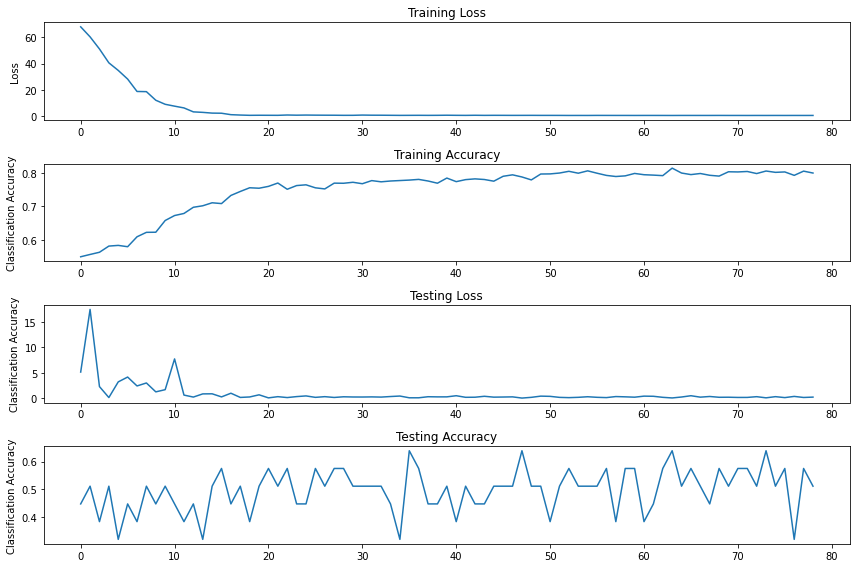

Min of Training Loss: 0.439555
Max of Training Accuracy: 0.814030
Mean of Training Loss: 5.060540
Mean of Training Accuracy: 0.752606
----
Max of Testing Accuracy: 0.639175
Min of Testing Loss: 0.084118
Mean of Testing Loss: 0.906964
Mean of Testing Accuracy: 0.497586


In [49]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [300]:
predict(model_bertsparse, criterion, test_dataloader, test_size)

ValueError: too many values to unpack (expected 2)

## Previous Models

self.layer1 = nn.Sequential(
    nn.Linear(768, 64, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 8, bias=True),
    nn.ReLU()
)

self.layer2 = nn.Sequential(
    nn.Linear(27, 5, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(5, 2, bias=True),
    nn.ReLU()
)

self.layer3 = nn.Sequential(
    nn.Linear(10, 1)  # 420
)

Min of Training Loss: 0.471854
Max of Training Accuracy: 0.785764
Mean of Training Loss: 0.505716
Mean of Training Accuracy: 0.758512
----
Max of Testing Accuracy: 0.639175
Mean of Testing Loss: 0.351359
Mean of Testing Accuracy: 0.454525

self.layer1 = nn.Sequential(
    nn.Linear(768, 64, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 5, bias=True),
    nn.ReLU()
)

self.layer2 = nn.Sequential(
    nn.Linear(27, 5, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(5, 2, bias=True),
    nn.ReLU()
)

self.layer3 = nn.Sequential(
    nn.Linear(7, 1)  # 420
)

Min of Training Loss: 0.467921
Max of Training Accuracy: 0.788694
Mean of Training Loss: 0.501997
Mean of Training Accuracy: 0.760402
----
Max of Testing Accuracy: 0.639175
Mean of Testing Loss: 0.348198
Mean of Testing Accuracy: 0.459259

# BERT + THREAD (Multi)

In [79]:
# BERT + SPARSE + THREAD (Multi)

scaler = StandardScaler()

# pheme_scaled = scaler.fit_transform(np.concatenate([pheme_sparse.values, pheme_thread_avg.values],axis=1))
# Train = np.concatenate([train, pheme_bert.values],axis=1)

# ext_sparse_scaled = scaler.transform(np.concatenate([ext_sparse.values, ext_thread_avg.values],axis=1))
# Test = np.concatenate([test, ext_bert.values],axis=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = pd.concat([pheme_sparse, pheme_thread], axis=1)
X_test = pd.concat([ext_sparse, ext_thread], axis=1)

# X_train = scaler.fit_transform(X_train.values)
X_train = np.concatenate([X_train, pheme_bert.values], axis=1)

# X_test = scaler.fit_transform(X_test.values)
X_test = np.concatenate([X_test, ext_bert.values],axis=1)

# Train = pd.concat([pheme_bert, pheme_sparse], axis=1)
# Test = pd.concat([ext_bert, ext_sparse], axis=1)

tensor_x1 = torch.Tensor(X_train).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(X_test).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

array([[-0.07906651,  0.15336594, -0.92330599, ...,  0.01090725,
         0.39039801,  0.89328313],
       [-0.07906651, -1.15520636, -0.92330599, ..., -4.06366165,
        -1.13204193, -1.11946589],
       [-0.07906651, -1.15520636, -0.92330599, ...,  0.10918358,
         0.25456694, -1.11946589],
       ...,
       [-0.07906651,  0.15336594, -0.92330599, ...,  0.15300712,
        -1.84091033, -1.11946589],
       [-0.07906651,  0.15336594, -0.92330599, ..., -4.06366165,
         1.33414098,  0.89328313],
       [-0.07906651, -1.15520636, -0.92330599, ..., -0.10647179,
         0.37766385, -1.11946589]])

In [31]:
pheme_temp = pd.concat([pheme_bert, pheme_thread_avg], axis=1)
ext_temp = pd.concat([ext_bert, ext_thread_avg], axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_temp, pheme_y, ext_temp, ext_y)
train_dataset = TensorDataset(tensor_x1, tensor_y1)
test_dataset = TensorDataset(tensor_x2, tensor_y2)

batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x1)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)


mean: tensor(245.7166), std: tensor(7631.2808)
torch.Size([5802, 1, 806]) torch.Size([485, 1, 806])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [33]:
# pheme_temp = pd.concat([pheme_sparse, pheme_thread_log], axis=1)
# ext_temp = pd.concat([ext_sparse, ext_thread_log], axis=1)

tensor_x1 = torch.Tensor(pheme_thread_avg.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)

tensor_x2 = torch.Tensor(ext_thread_avg.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)

tensor_x1_2= torch.Tensor(pheme_bert.values).unsqueeze(1)
tensor_x2_2 = torch.Tensor(ext_bert.values).unsqueeze(1)

train_dataset = TensorDataset(tensor_x1, tensor_x1_2, tensor_y1)
test_dataset = TensorDataset(tensor_x2, tensor_x2_2, tensor_y2)


In [39]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_x1_2.shape,tensor_x2_2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)


mean: tensor(6030.6250), std: tensor(75728.3438)
torch.Size([5802, 1, 38]) torch.Size([485, 1, 38])
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [40]:
class sparse_thread_net_multi(nn.Module):
    def __init__(self):
        super(sparse_thread_net_multi, self).__init__()  # 1*20


        self.layer1 = nn.Sequential(
            nn.Linear(38, 8, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(8, 2, bias=True),  # 420
        )
        self.layer2 = nn.Sequential(
            nn.Linear(768, 64, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 8, bias=True),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(10, 1)  # 420
        )

        self.drop_2 = nn.Dropout(0.2)

    def forward(self, sparse, embedding):
        x1 = self.layer1(sparse)
        x2 = self.layer2(embedding)
        
        x = torch.cat((x1.squeeze(1), x2.squeeze(1)), dim=1)
        x = self.layer3(x)
        return x


In [43]:
set_seed()
model_sparsethread_multi = sparse_thread_net_multi()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_sparsethread_multi.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []


epochs = 200

PATH = "./Model/state_dict_sparse_thread_model_multi.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)


In [46]:
train_acc, train_loss, val_acc, val_loss_list = train3(model=model_sparsethread_multi, num_epochs=epochs,patience=15, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/199	Train) Acc: 0.5495, Loss: 68.0819
		Validation) Acc: 0.4474 Loss:5.1839
Epoch 2/199	Train) Acc: 0.5629, Loss: 51.1780
		Validation) Acc: 0.3835 Loss:2.3340
Epoch 4/199	Train) Acc: 0.5834, Loss: 34.8244
		Validation) Acc: 0.3196 Loss:3.2573
Epoch 6/199	Train) Acc: 0.6091, Loss: 18.7582
		Validation) Acc: 0.3835 Loss:2.4596
Epoch 8/199	Train) Acc: 0.6227, Loss: 12.0562
		Validation) Acc: 0.4474 Loss:1.3011
		Saving the best model w/ loss 8.9675
Epoch 10/199	Train) Acc: 0.6725, Loss: 7.5433
		Validation) Acc: 0.4474 Loss:7.7603
		Saving the best model w/ loss 7.5433
		Saving the best model w/ loss 6.1989
Epoch 12/199	Train) Acc: 0.6972, Loss: 3.1838
		Validation) Acc: 0.4474 Loss:0.2800
		Saving the best model w/ loss 3.1838
		Saving the best model w/ loss 2.8038
Epoch 14/199	Train) Acc: 0.7106, Loss: 2.2419
		Validation) Acc: 0.5113 Loss:0.9200
		Saving the best model w/ loss 2.2419
		Saving the best model w/ loss 2.1490
Epoch 16/199	Train) Acc: 0.7325, Loss: 1.0469
		Validat

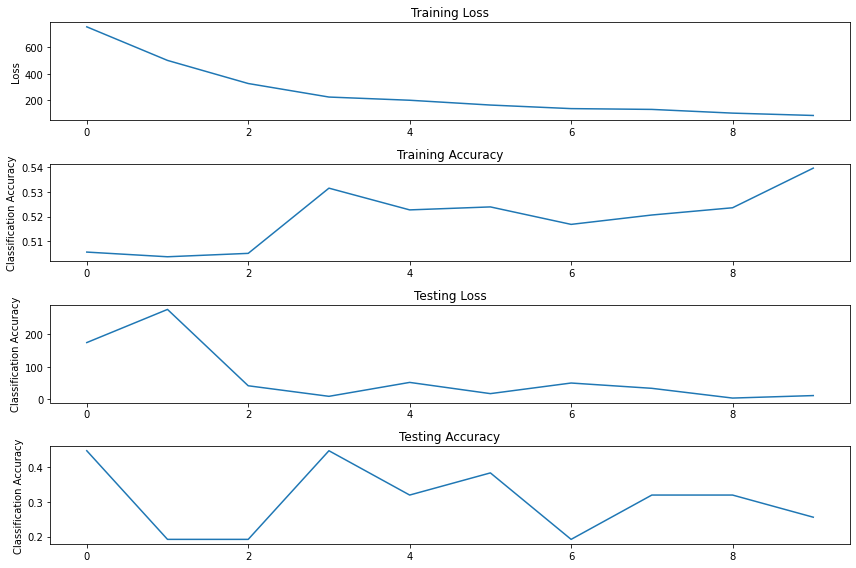

Min of Training Loss: 84.952446
Max of Training Accuracy: 0.539642
Mean of Training Loss: 262.715087
Mean of Training Accuracy: 0.519373
----
Max of Testing Accuracy: 0.447423
Min of Testing Loss: 4.358668
Mean of Testing Loss: 67.619078
Mean of Testing Accuracy: 0.306804


In [45]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

# (V) BERT + SPARSE + THREAD + POS

In [444]:
def convert_df_to_unsqueezed_tensor(trainX, trainY, testX, testY, TrainX2=None, TestX2=None):
    tensor_x1 = torch.Tensor(trainX).unsqueeze(1)
    tensor_y1 = torch.Tensor(trainY.values).unsqueeze(1)

    tensor_x2 = torch.Tensor(testX).unsqueeze(1)
    tensor_y2 = torch.Tensor(testY).unsqueeze(1)
    if ((TrainX2 is None) | (TestX2 is None)):
        
        return tensor_x1, tensor_y1, tensor_x2, tensor_y2
    elif (TrainX2 is not None & TestX2 is not None):
        tensor_x1_2= torch.Tensor(TrainX2.values).unsqueeze(1)
        tensor_x2_2 = torch.Tensor(TestX2.values).unsqueeze(1)
        return tensor_x1, tensor_x1_2, tensor_y1, tensor_x2, tensor_x2_2, tensor_y2

In [605]:
scaler = StandardScaler()
pheme_temp = pd.concat([pheme_sparse_final, pheme_pos_final, pheme_thread_final_avg],axis=1)
ext_temp = pd.concat([ext_sparse_final, ext_pos_final, ext_thread_final_avg],axis=1)

# pheme_temp = pd.concat([pheme_sparse_final, pheme_pos_final, pheme_thread_final_avg, pheme_bert_simple_normal],axis=1)
# ext_temp = pd.concat([ext_sparse_final, ext_pos_final, ext_thread_final_avg, ext_bert_simple_normal],axis=1)

pheme_temp = scaler.fit_transform(pheme_temp)
ext_temp = scaler.fit_transform(ext_temp)

pheme_temp =np.concatenate([pheme_temp, pheme_bert_simple_normal], axis=1)
ext_temp = np.concatenate([ext_temp, ext_bert_simple_normal],axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_temp, pheme_y, ext_temp, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 16

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0444), std: tensor(0.4548)
torch.Size([5802, 1, 867]) torch.Size([485, 1, 867])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [606]:
class BERT_all_net(nn.Module):
    def __init__(self):
        super(BERT_all_net, self).__init__()  # 1*20
        self.fc1 = nn.Linear(867, 80)  # 420
        self.fc2 = nn.Linear(80, 12, bias=True)
        self.fc3 = nn.Linear(12, 1, bias=True)

        torch.nn.init.kaiming_uniform_(self.fc1.weight)
        torch.nn.init.kaiming_uniform_(self.fc2.weight)
        torch.nn.init.kaiming_uniform_(self.fc3.weight)
        self.bn1 = torch.nn.BatchNorm1d(8)


        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        # x = F.elu(self.fc1(x))
        x = F.elu(self.fc1(x))
        x = self.drop_3(x)
        # x = self.drop_2(F.elu(self.fc2(x)))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x


In [607]:
set_seed(42)
model_all_concat = BERT_all_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_all_concat.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
optimizer = AdamW(model_all_concat.parameters(),
                    lr=5e-5,    # Default learning rate
                    eps=1e-8,    # Default epsilon value
                    weight_decay=1e-6
                    )
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 150

PATH = "./Model/state_dict_all_model.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [608]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_all_concat, num_epochs=epochs, patience=99, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/149	Train) Acc: 0.6201, Loss: 0.6661
		Validation) Acc: 0.5134 Loss:0.7429
			Saving the best model w/ val loss 0.7429
Epoch 2/149	Train) Acc: 0.7609, Loss: 0.5063
		Validation) Acc: 0.4907 Loss:0.8588
Epoch 4/149	Train) Acc: 0.7983, Loss: 0.4606
		Validation) Acc: 0.4948 Loss:0.9062
Epoch 6/149	Train) Acc: 0.7985, Loss: 0.4559
		Validation) Acc: 0.5278 Loss:0.8292
Epoch 8/149	Train) Acc: 0.8028, Loss: 0.4402
		Validation) Acc: 0.4845 Loss:0.9129
Epoch 10/149	Train) Acc: 0.8149, Loss: 0.4249
		Validation) Acc: 0.4351 Loss:0.9764
Epoch 12/149	Train) Acc: 0.8223, Loss: 0.4136
		Validation) Acc: 0.4701 Loss:0.9365
Epoch 14/149	Train) Acc: 0.8166, Loss: 0.4114
		Validation) Acc: 0.4990 Loss:0.8574
Epoch 16/149	Train) Acc: 0.8178, Loss: 0.4101
		Validation) Acc: 0.4928 Loss:0.8649
Epoch 18/149	Train) Acc: 0.8285, Loss: 0.4001
		Validation) Acc: 0.4124 Loss:1.0057
Epoch 20/149	Train) Acc: 0.8316, Loss: 0.3967
		Validation) Acc: 0.5052 Loss:0.8754
Epoch 22/149	Train) Acc: 0.8268, Loss

KeyboardInterrupt: 

In [564]:
model = BERT_all_net()
PATH = './Model/state_dict_all_model.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.6825
Precision Score:	0.8620
Recall Score:		0.6938
f1_score:		0.6406
Test_loss:		0.6312


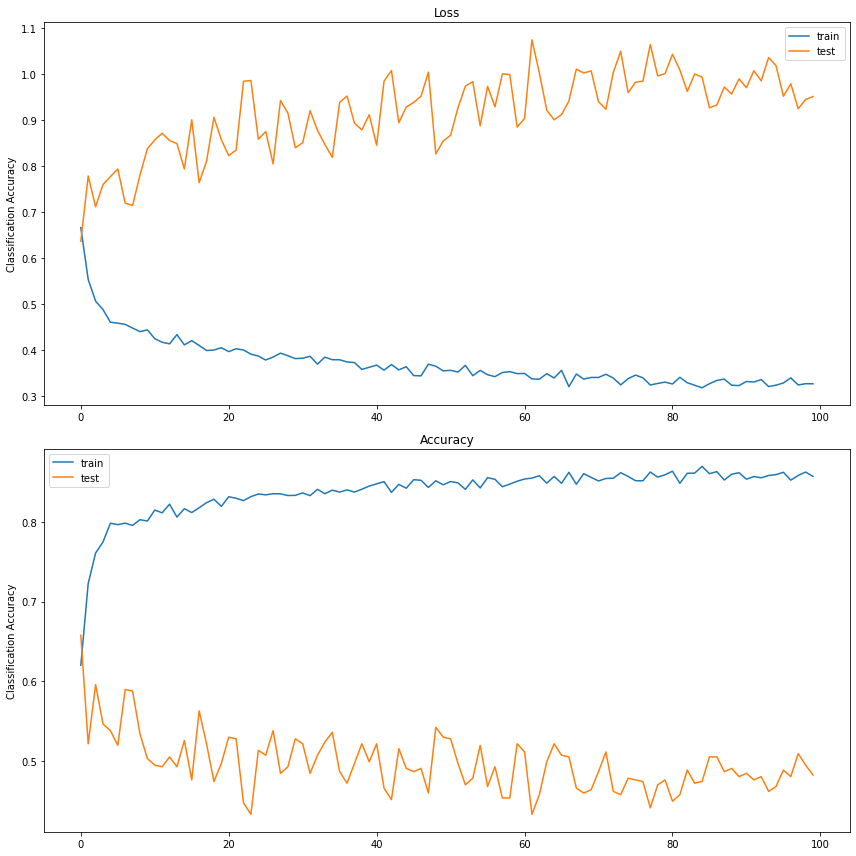

Min of Training Loss: 0.318041
Max of Training Accuracy: 0.869700
Mean of Training Loss: 0.371581
Mean of Training Accuracy: 0.838047
------------
Max of Testing Accuracy: 0.657732
Min of Testing Loss: 0.636421
Mean of Testing Loss: 0.915019
Mean of Testing Accuracy: 0.497216
------------


In [583]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [ ]:
__MLP.set_seed(42)
model_sparse_pos = sparse_pos_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_sparse_pos.parameters(), lr=8e-3,eps=1e-8, weight_decay=1e-4)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
optimizer = AdamW(model_sparse_pos.parameters(),
                    lr=5e-5,    # Default learning rate
                    eps=1e-8,    # Default epsilon value
                    weight_decay=1e-6
                    )
train_loss = []
train_accuracy = []

epochs = 100

PATH = "./Model/state_dict_sparse_pos_model.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

# Sparse POS

In [ ]:
scaler = StandardScaler()
pheme_temp = scaler.fit_transform(pd.concat([pheme_sparse_final, pheme_pos_final],axis=1))
ext_temp = scaler.transform(pd.concat([ext_sparse_final, ext_pos_final],axis=1))

pheme_temp = pd.concat([pheme_sparse_final, pheme_pos_final],axis=1)
ext_temp = pd.concat([ext_sparse_final, ext_pos_final],axis=1)

# pheme_sparse_bert_spread = pd.concat([pheme_sparse, pheme_thread, pheme_bert],axis=1)
# ext_sparse_bert_spread = pd.concat([ext_sparse, ext_thread_log, ext_bert],axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_temp.values, pheme_y, ext_temp.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

In [ ]:
class sparse_pos_net(nn.Module):
    def __init__(self):
        super(sparse_pos_net, self).__init__()  # 1*20
        self.fc1 = nn.Linear(49, 6, bias=True)  # 420
        # self.fc2 = nn.Linear(12, 7, bias=True)
        self.fc3 = nn.Linear(6, 1, bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_5 = nn.Dropout(0.5)
        self.drop_2 = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        # x = F.elu(self.fc1(x))
        x = F.elu(self.fc3(x))
        # x = F.elu(self.fc2(x))
        # x = self.fc3(x)
        return x


In [529]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_all_concat, num_epochs=epochs, patience=50, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/149	Train) Acc: 0.4938, Loss: 16310.8563
		Validation) Acc: 0.5010 Loss:313.5882
Epoch 2/149	Train) Acc: 0.5365, Loss: 8550.0103
		Validation) Acc: 0.4041 Loss:440.4749
Epoch 4/149	Train) Acc: 0.5352, Loss: 4724.3980
		Validation) Acc: 0.4495 Loss:213.0245
Epoch 6/149	Train) Acc: 0.5424, Loss: 3420.6190
		Validation) Acc: 0.5072 Loss:151.8680
Epoch 8/149	Train) Acc: 0.5386, Loss: 3192.4132
		Validation) Acc: 0.4866 Loss:168.1125
Epoch 10/149	Train) Acc: 0.5215, Loss: 2619.0157
		Validation) Acc: 0.5175 Loss:126.2218
Epoch 12/149	Train) Acc: 0.5438, Loss: 2112.0878
		Validation) Acc: 0.4866 Loss:119.0229
Epoch 14/149	Train) Acc: 0.5398, Loss: 1568.7612
		Validation) Acc: 0.5423 Loss:83.2300
Epoch 16/149	Train) Acc: 0.5362, Loss: 1374.3977
		Validation) Acc: 0.5505 Loss:70.4796
Epoch 18/149	Train) Acc: 0.5526, Loss: 1057.9474
		Validation) Acc: 0.5216 Loss:70.1254
Epoch 20/149	Train) Acc: 0.5360, Loss: 872.4038
		Validation) Acc: 0.4928 Loss:67.8836
Epoch 22/149	Train) Acc: 0.548

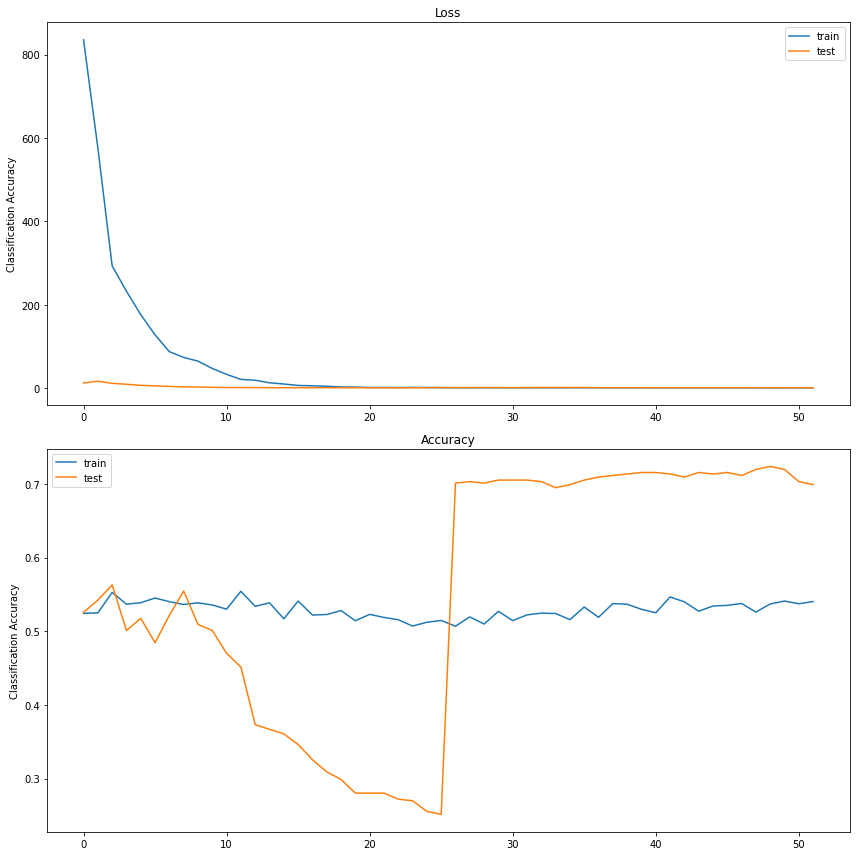

Min of Training Loss: 0.684557
Max of Training Accuracy: 0.554292
Mean of Training Loss: 51.102476
Mean of Training Accuracy: 0.529138
------------
Max of Testing Accuracy: 0.723711
Min of Testing Loss: 0.737866
Mean of Testing Loss: 2.202679
Mean of Testing Accuracy: 0.554718
------------


In [520]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [521]:
model = BERT_all_net()
PATH = './Model/state_dict_all_model.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.2804
Precision Score:	0.8333
Recall Score:		0.0678
f1_score:		0.2475
Test_loss:		0.7379


# (V) BERT + SPARSE + THREAD + POS (Multi)

In [396]:
# pheme_pos_final = pheme_pos_final.drop(['#','s'],axis=1)
# ext_pos_final = ext_pos_final.drop(['#','s'],axis=1)
# pheme_pos_final.to_csv("./data/_PHEME_postags", index = False)
# ext_pos_final.to_csv("./data/_PHEMEext_postags",index = False)

In [584]:
scaler = StandardScaler()
pheme_temp = scaler.fit_transform(pd.concat([pheme_sparse_final, pheme_pos_final, pheme_thread_final_avg],axis=1))
ext_temp = scaler.transform(pd.concat([ext_sparse_final, ext_pos_final, ext_thread_final_avg],axis=1))

# pheme_sparse_bert_spread = pd.concat([pheme_sparse, pheme_thread, pheme_bert],axis=1)
# ext_sparse_bert_spread = pd.concat([ext_sparse, ext_thread_log, ext_bert],axis=1)
# pheme_temp = pd.concat([pheme_temp, pheme_bert_simple_normal],axis=1)
# ext_temp = pd.concat([ext_temp, ext_bert_simple_normal],axis=1)
# pheme_temp =np.concatenate([pheme_temp, pheme_bert_simple_normal], axis=1)
# ext_temp = np.concatenate([ext_temp, ext_bert_simple_normal],axis=1)

tensor_x1 = torch.Tensor(pheme_temp).unsqueeze(1)
tensor_x1_2= torch.Tensor(pheme_bert_simple_normal.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y).unsqueeze(1)

tensor_x2 = torch.Tensor(ext_temp).unsqueeze(1)
tensor_x2_2 = torch.Tensor(ext_bert_simple_normal.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y).unsqueeze(1)


train_dataset = TensorDataset(tensor_x1, tensor_x1_2, tensor_y1)
test_dataset = TensorDataset(tensor_x2, tensor_x2_2, tensor_y2)

batch_size = 8

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_x1_2.shape,tensor_x2_2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(-0.0124), std: tensor(0.9485)
torch.Size([5802, 1, 99]) torch.Size([485, 1, 99])
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [591]:
class BERT_all_net_multi(nn.Module):
    def __init__(self):
        super(BERT_all_net_multi, self).__init__()  # 1*20


        self.layer1 = nn.Sequential(
            nn.Linear(99, 12, bias=True),  # 420
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(12,4, bias=True),  # 420
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(768, 64, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 8, bias=True),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(12, 1)  # 420
        )

    def forward(self, sparse, embedding):
        x1 = self.layer1(sparse)
        x2 = self.layer2(embedding)
        
        x = torch.cat((x1.squeeze(1), x2.squeeze(1)), dim=1)
        x = self.layer3(x)
        return x

In [592]:
from __MLP import train_multi

In [594]:
set_seed()
model_all_multi = BERT_all_net_multi()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_all_multi.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
optimizer = AdamW(model_all_multi.parameters(),
                    # lr=5e-5,    # Default learning rate
                    lr=5e-5,    # Default learning rate
                    eps=1e-8,    # Default epsilon value
                    weight_decay=1e-6
                    )
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []


epochs = 50

PATH = "./Model/state_dict_all_model_multi.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [595]:
def train3(model, num_epochs, criterion, optimizer, scheduler, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            sparse, embedding, labels = data
            sparse, embedding, labels = sparse.float(), embedding.float(), labels.float().squeeze(1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(sparse, embedding)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs.squeeze(1) > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * sparse.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_sparse, val_embedding, val_labels = data
                    val_sparse, val_embedding, val_labels = val_sparse.float(), val_embedding.float(), val_labels.float().squeeze(1)
                    val_outputs = model(val_sparse, val_embedding)
                    # _, val_preds = torch.max(val_outputs, 1)
                    # print("val_outputs size:",val_outputs.size())
                    # print("val_label size:",val_label.size())
                    val_preds = val_outputs.squeeze(1) > 0.0
                    # print("pred size:",val_preds.size())

                    # print("Length of val_preds:",val_preds.size())
                    val_preds_list.append(val_preds)
                    val_label_list.append(val_labels)
                    v_loss = criterion(val_outputs, val_labels.unsqueeze(1))
                    val_loss += (v_loss.item() * val_labels.size(0))
                    val_corrects += torch.sum(val_preds == val_labels)
                    # print("== length",val_preds == val_label)
                    # accuracy = (preds == b_labels).cpu().numpy().mean() * 100

                    # print("val_corrects:",val_corrects)
                # print("length of one batch")
                # print("FINAL val_corrects:",val_corrects)
                # print("test_size:",test_size)
                    
                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

In [596]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_multi(model=model_all_multi, num_epochs=epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

Epoch 0/49	Train) Acc: 0.6231, Loss: 0.6759
		Validation) Acc: 0.2515 Loss:0.1646
			Saving the best model w/ val loss 0.1646
Epoch 2/49	Train) Acc: 0.7811, Loss: 0.5374
		Validation) Acc: 0.2515 Loss:0.1023
			Saving the best model w/ val loss 0.1023
			Saving the best model w/ val loss 0.0941
Epoch 4/49	Train) Acc: 0.7846, Loss: 0.4818
		Validation) Acc: 0.0000 Loss:0.4017
			Saving the best model w/ val loss 0.0837
Epoch 6/49	Train) Acc: 0.7896, Loss: 0.4607
		Validation) Acc: 0.2515 Loss:0.0292
			Saving the best model w/ val loss 0.0292
Epoch 8/49	Train) Acc: 0.8006, Loss: 0.4506
		Validation) Acc: 0.2515 Loss:0.0625
Epoch 10/49	Train) Acc: 0.8116, Loss: 0.4327
		Validation) Acc: 0.2515 Loss:0.0451
Finishing the Model: Val Loss is not decreasing...
[0.029227467971978727, 0.19208747971918166, 0.06249899028502789, 0.04849550932953038, 0.04505658592145467]


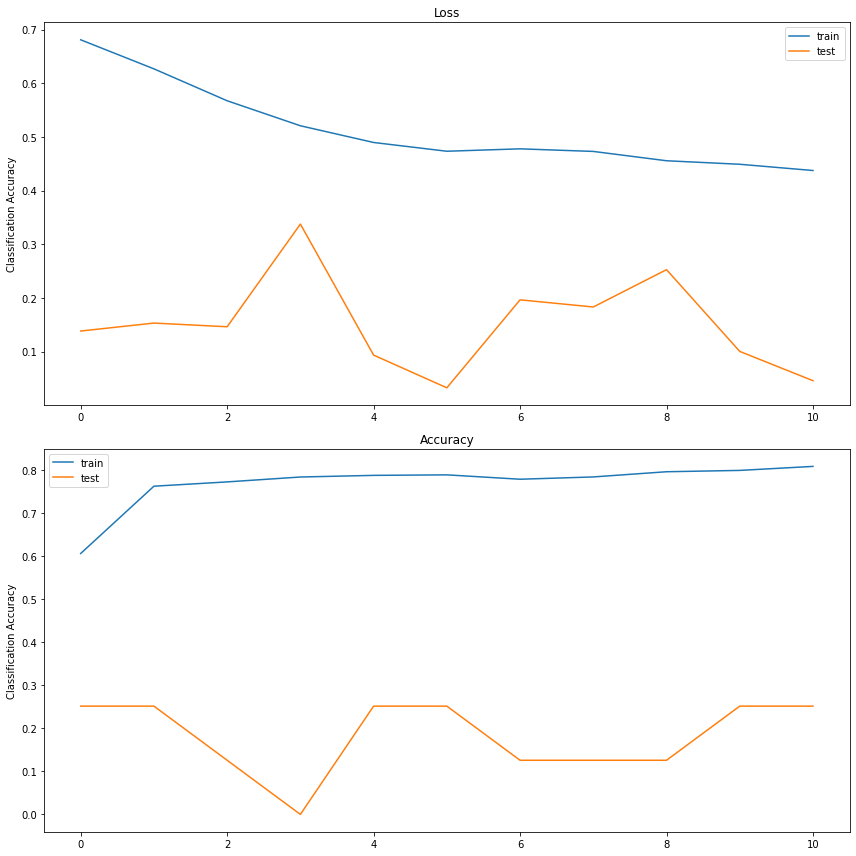

Min of Training Loss: 0.437369
Max of Training Accuracy: 0.808514
Mean of Training Loss: 0.513736
Mean of Training Accuracy: 0.769829
------------
Max of Testing Accuracy: 0.251546
Min of Testing Loss: 0.032585
Mean of Testing Loss: 0.152717
Mean of Testing Accuracy: 0.182943
------------


In [384]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

# TESTING

In [ ]:
pheme_AVGw2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_event = pd.read_csv('./data/_PHEME_text.csv')['Event']
pheme_bert = fetchdata('pheme','bert')
pheme_bert = pd.read_csv('./data/_PHEME_Bert_simple.csv')
pheme_bert_bracket = pd.read_csv('./data/_PHEME_Bert_brackets.csv')
pheme_thread =  fetchdata('pheme','thread')
pheme_thread_log = pd.read_csv('./data/_PHEME_thread_log.csv')
pheme_thread_avg = pd.read_csv('./data/_PHEME_thread_avg.csv')


ext_AVGw2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event
ext_bert = fetchdata('ext','bert')
ext_bert = pd.read_csv('./data/_PHEMEext_Bert_simple.csv')
ext_bert_bracket = pd.read_csv('./data/_PHEMEext_Bert_brackets.csv')

ext_thread = fetchdata('ext','thread')
ext_thread_log = pd.read_csv('./data/_PHEMEext_thread_log.csv')
ext_thread_avg= pd.read_csv('./data/_PHEMEext_thread_avg.csv')

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')
rhi_bert = fetchdata('rhi','bert')

In [18]:
model_paths = ["./Model/state_dict_sparse_model.pt",
               "./Model/state_dict_w2v_model.pt",
               "./Model/state_dict_bert_model.pt",
               "./Model/state_dict_thread_model.pt",
               "./Model/state_dict_w2v_sparse_model.pt", 
               "./Model/state_dict_bert_sparse_model.pt",
               "./Model/state_dict_bert_sparse_multi.pt",
               "./Model/state_dict_sparse_thread_model_multi.pt",
                "./Model/state_dict_bert_sparse_model.pt",
                "./Model/state_dict_bert_thread_model.pt",
                "./Model/state_dict_bert_sparse_thread_model_multi.pt"
               ]


# Sparse

In [34]:
#pheme_sparse -> pheme_scaled -> tensor
scaler = StandardScaler()
pheme_scaled = pd.DataFrame(scaler.fit_transform(pheme_sparse))
ext_scaled = pd.DataFrame(scaler.transform(ext_sparse))

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_scaled,pheme_y,ext_scaled,ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 16
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_size, test_size = int(tensor_y1.size(0)), int(tensor_y2.size(0))

print("Training: ",tensor_x1.shape,"/", tensor_x2.shape)
print("Testing2: ",tensor_y1.shape,"/", tensor_y2.shape)
print("Train Size",train_size,"/ Test Size",test_size)
PATH = './Model/BERTweet_raw_to_fine_tune_SimplePrdep.pt'


Training:  torch.Size([5802, 1, 36]) / torch.Size([485, 1, 36])
Testing2:  torch.Size([5802, 1]) / torch.Size([485, 1])
Train Size 5802 / Test Size 485


In [ ]:
# bert_classifier.load_state_dict(torch.load(PATH))
# testing_process(bert_classifier, X_val, y_val)
predict(model, criterion, val_dataloader, val_size)

In [24]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

NameError: name 'bert_predict' is not defined

In [ ]:
PATH = './Model/BERTweet_raw_to_fine_tune_SimplePrdep.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_val, y_val)

In [ ]:
PATH = './Model/BERTweet_raw_to_fine_tune_SimplePrep.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_val, y_val)

In [ ]:
def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_label)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss = val_loss/test_size
    val_acc = val_corrects.double() / val_size

    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/test_size))
    
    print(classification_report(y_test, result))

    return val_acc, val_loss, val_corrects, val_preds_list, val_label_list